# Euphoria Project: Understanding Island Happiness
Made by Matteo Bruni, Matteo Rapisarda, and Federico Romano Gargarella

## Context
In the virtual world of **Euphoria**, an expansive digital archipelago, each island offers unique experiences and environments to its inhabitants. This project aims to explore and understand the characteristics that contribute to the happiness of island residents. By segmenting islands based on happiness levels, we can help similar travelers find their ideal destinations within Euphoria.

### Goals
- Identify key factors influencing the happiness levels on different islands.
- Segment islands to create traveler profiles, matching visitors to islands with similar features and happiness scores.
- Explore geographic, environmental, and amenity-based patterns to understand how these elements correlate with happiness and loyalty.

#### **Type of Problem**: **Clustering**

This is a **clustering problem** because the goal is to uncover meaningful groups of islands based on their happiness levels and related features. By testing different models and validating the clusters, we can identify distinct island segments for better traveler experiences.

### **Testing Different Models**

#### **1. KMeans Clustering**
   - Algorithm:
     - Partition data into `k` clusters.
     - Minimize intra-cluster variance (points are closer to their centroid).
   - Pros:
     - Works well for numeric data.
     - Easy to implement.
   - Cons:
     - Requires predefining `k`.
     - Sensitive to outliers.

#### **2. DBSCAN**
   - Algorithm:
     - Groups points based on density.
     - Identifies noise and finds arbitrarily shaped clusters.
   - Pros:
     - No need to specify the number of clusters.
     - Robust to noise and outliers.
   - Cons:
     - Struggles with varying densities in clusters.

#### **3. Hierarchical Clustering**
   - Algorithm:
     - Creates a tree-like structure (dendrogram) to show cluster relationships.
   - Pros:
     - Visual representation of cluster hierarchy.
   - Cons:
     - Computationally expensive for large datasets.


## EDA

### Setting Up and Exploring Basic Info

In [198]:
import pandas as pd

pd.set_option('display.max_colwidth', None)  # Allow full column width display
pd.set_option('display.colheader_justify', 'right')  # Align column headers to the left (for header alignment only)
pd.set_option('display.width', 1000)         # Set a larger width for the entire display

# Load the dataset to inspect its structure and content
euphoria_data = pd.read_csv("euphoria.csv")

# Display basic information and the first few rows to understand the dataset
print("Basic Info:")
print(euphoria_data.info())

print("\nFirst 5 Rows:")
print(euphoria_data.head())

# Check for duplicates
duplicates = euphoria_data.duplicated().sum()
print(f"\nNumber of Duplicate Rows: {duplicates}")

print("\nSummary Statistics:")
print(euphoria_data.describe(include='all'))

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99492 entries, 0 to 99491
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   referral_friends         89572 non-null  float64
 1   water_sources            89536 non-null  float64
 2   shelters                 89382 non-null  float64
 3   fauna_friendly           35163 non-null  object 
 4   island_size              89578 non-null  float64
 5   creation_time            89462 non-null  float64
 6   region                   89306 non-null  object 
 7   happiness_metric         89566 non-null  object 
 8   features                 75035 non-null  object 
 9   happiness_index          89455 non-null  float64
 10  loyalty_score            89546 non-null  float64
 11  total_refunds_requested  89705 non-null  float64
 12  trade_goods              89673 non-null  object 
 13  x_coordinate             89491 non-null  float64
 14  avg_time_i

### Exploring Null Values


Missing Data Summary:
                         Missing Values  Percentage (%)
fauna_friendly                    64329       64.657460
features                          24457       24.581876
nearest_city                      10239       10.291280
region                            10186       10.238009
entry_fee                         10126       10.177703
shelters                          10110       10.161621
y_coordinate                      10099       10.150565
happiness_index                   10037       10.088248
creation_time                     10030       10.081213
x_coordinate                      10001       10.052064
island_id                          9972       10.022916
avg_time_in_euphoria               9966       10.016886
water_sources                      9956       10.006835
loyalty_score                      9946        9.996784
happiness_metric                   9926        9.976682
referral_friends                   9920        9.970651
island_size              

<Figure size 1200x600 with 0 Axes>

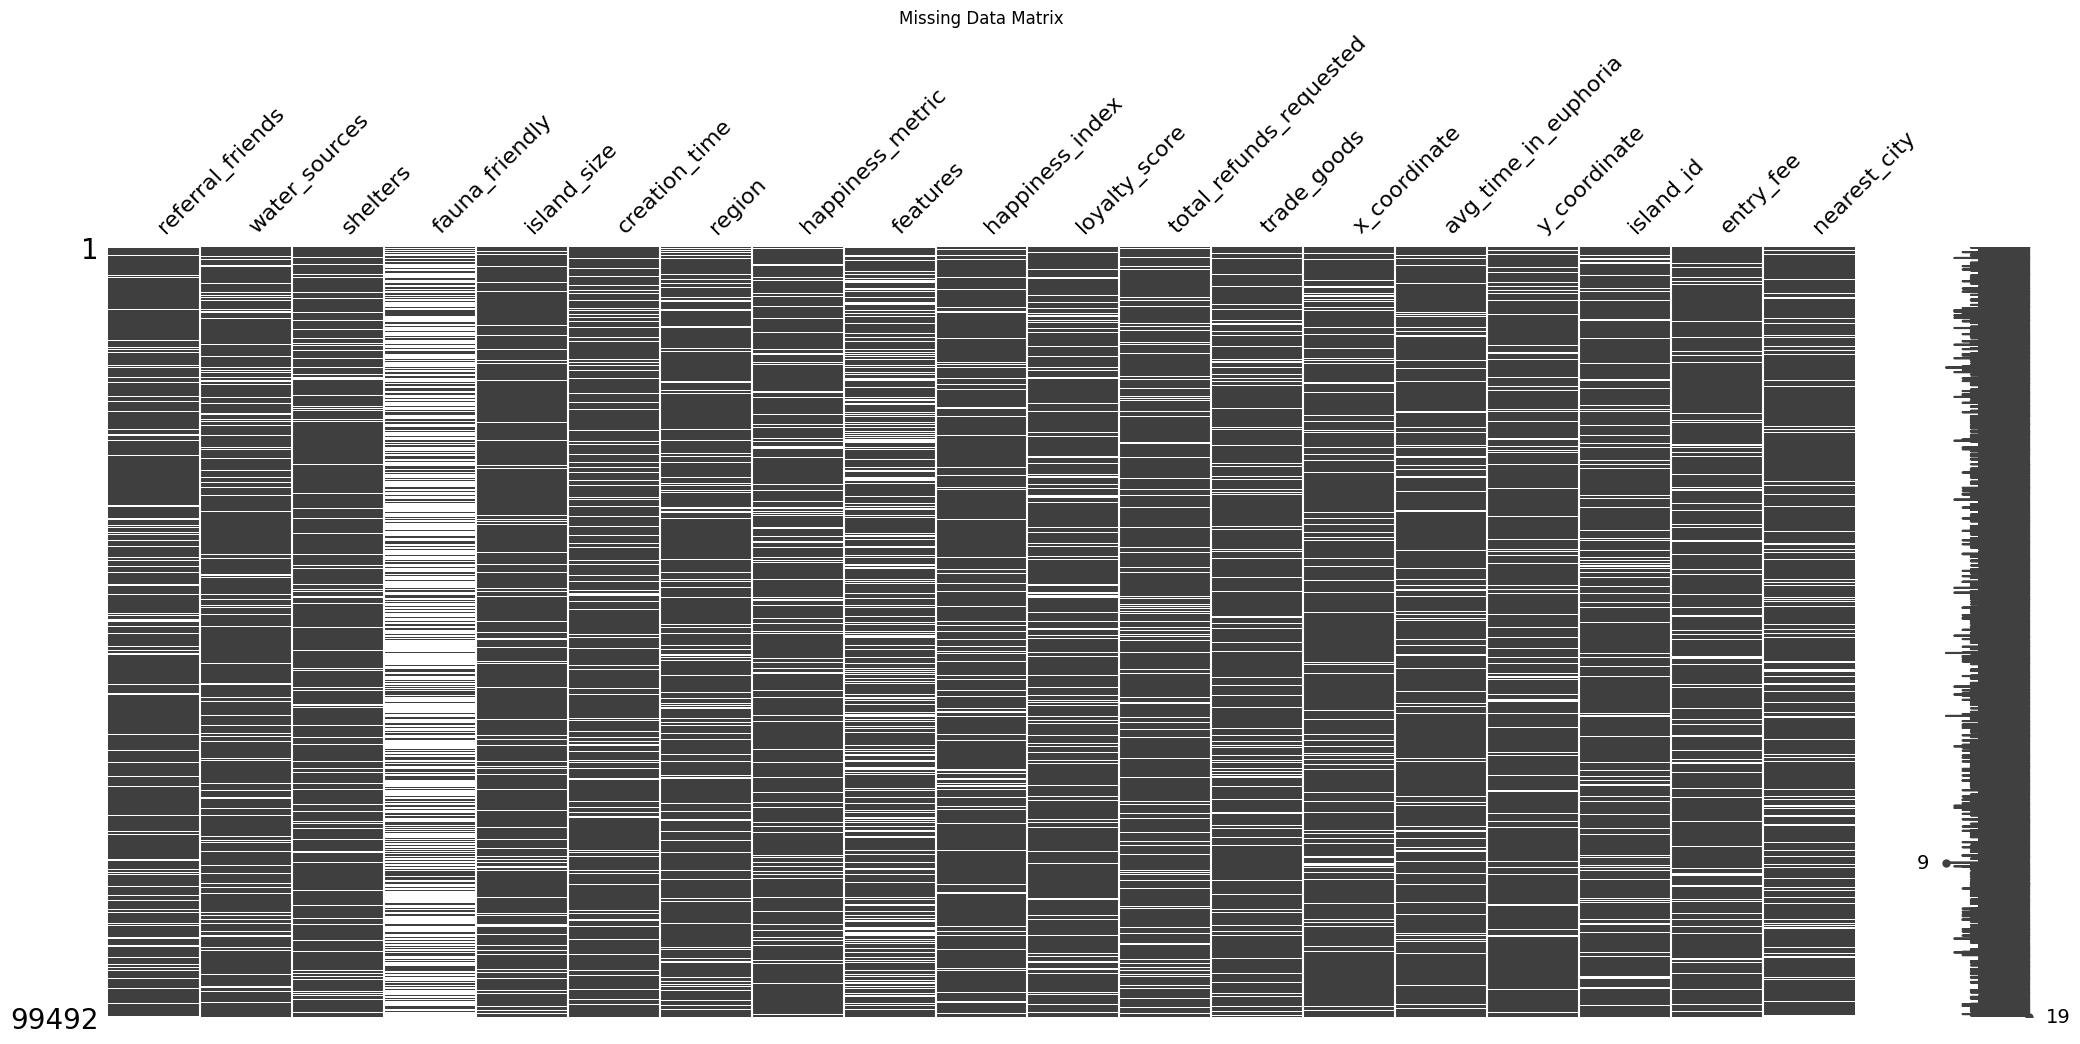

In [199]:
import matplotlib.pyplot as plt

# Calculate missing values and percentages
missing_values_count = euphoria_data.isnull().sum()
missing_percentage = (missing_values_count / len(euphoria_data)) * 100

# Combine into a dataframe
missing_data_summary = pd.DataFrame({
    "Missing Values": missing_values_count,
    "Percentage (%)": missing_percentage
}).sort_values(by="Missing Values", ascending=False)

# Display the dataframe
print("\nMissing Data Summary:")
print(missing_data_summary)

# Visualize missing data
import missingno as msno

# Missing data matrix
plt.figure(figsize=(12, 6))
msno.matrix(euphoria_data)
plt.title("Missing Data Matrix")
plt.show()

#### Correlation Heatmap of Missing Data

<Figure size 1200x600 with 0 Axes>

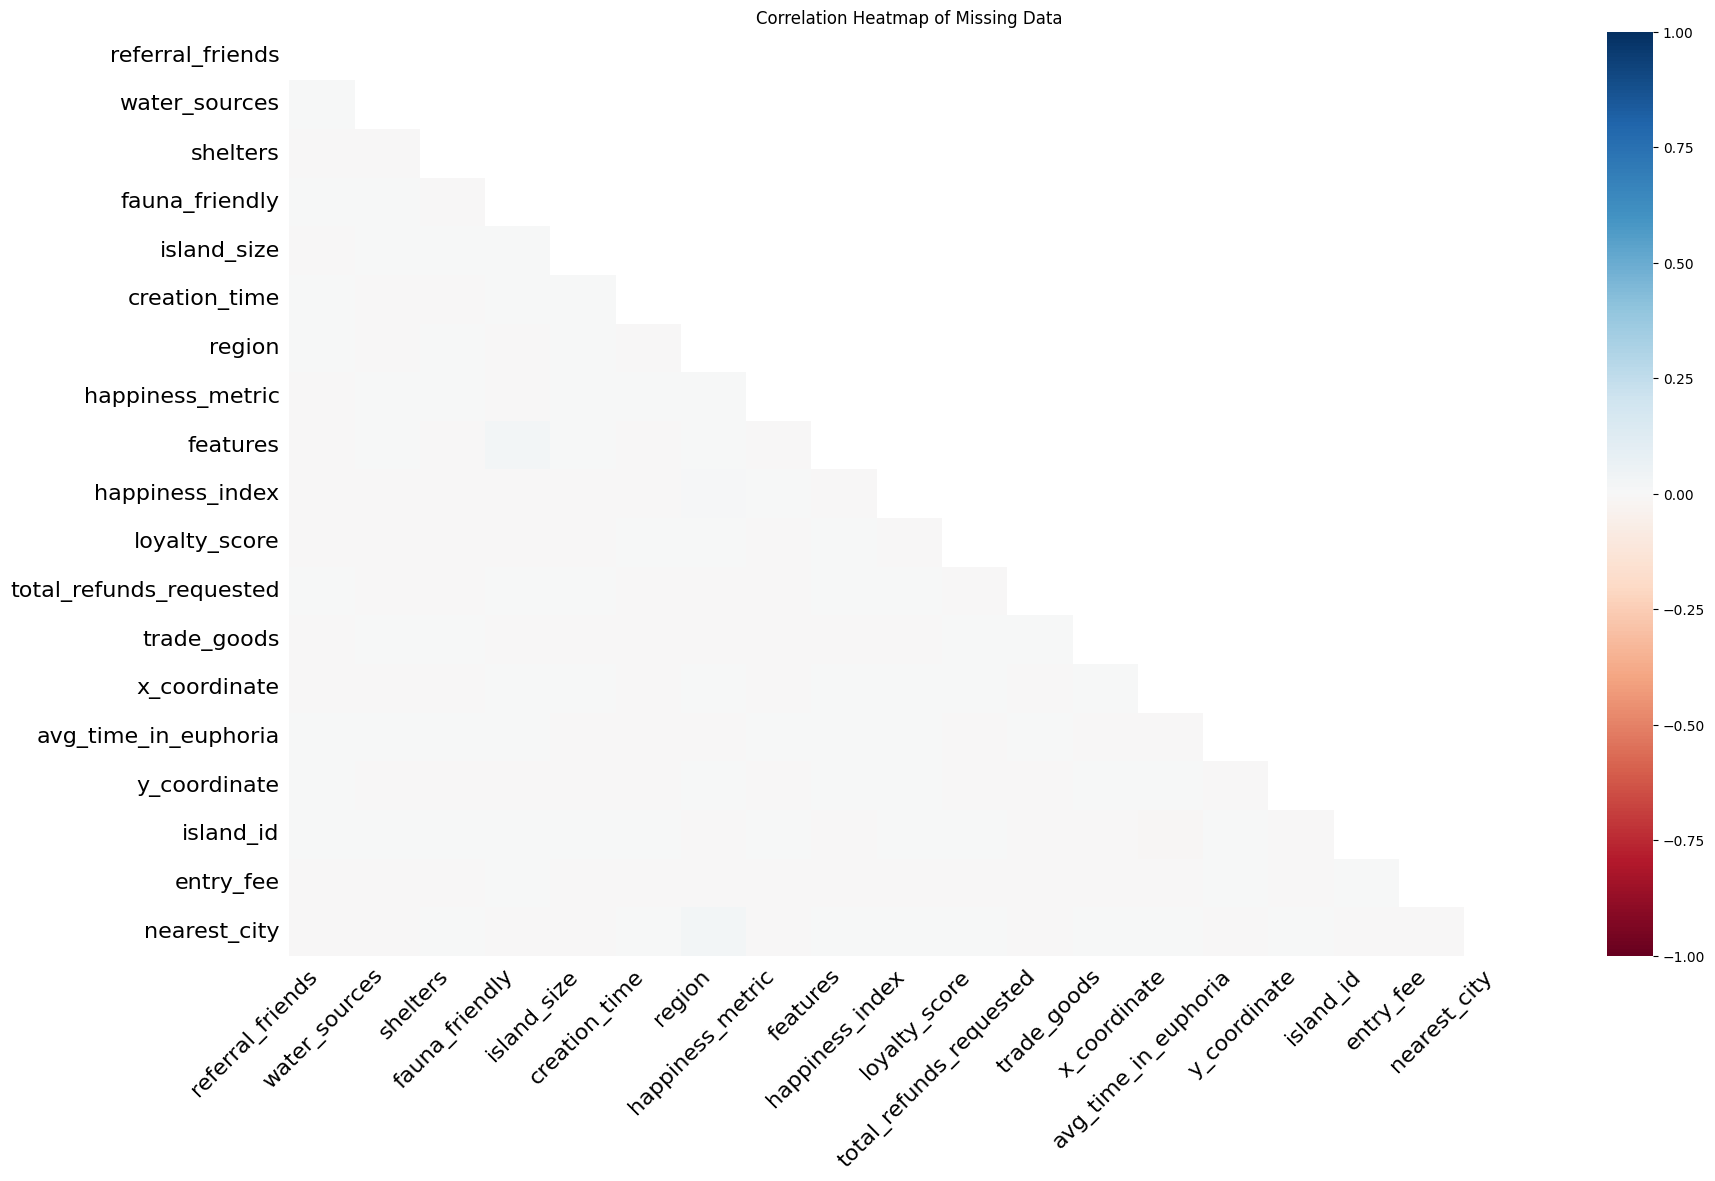

In [200]:
plt.figure(figsize=(12, 6))
msno.heatmap(euphoria_data)
plt.title("Correlation Heatmap of Missing Data")
plt.show()

### Exploring Categorical Variables

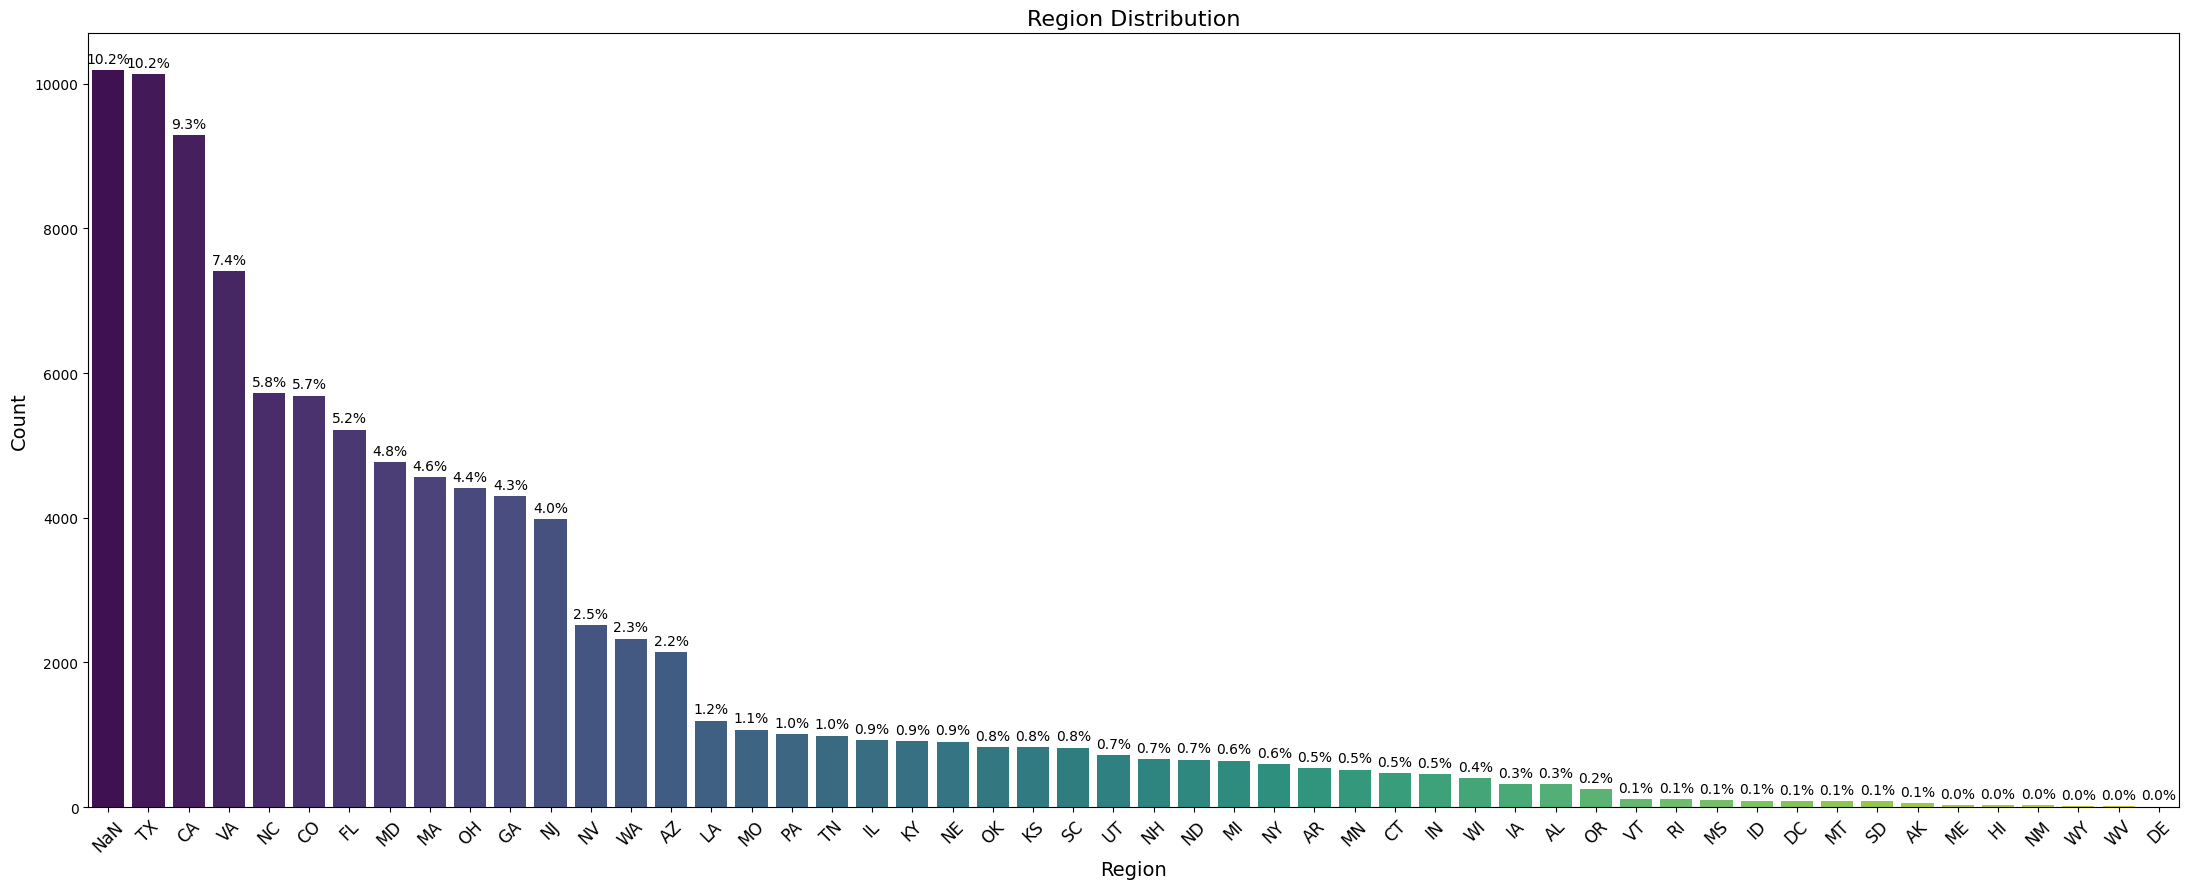

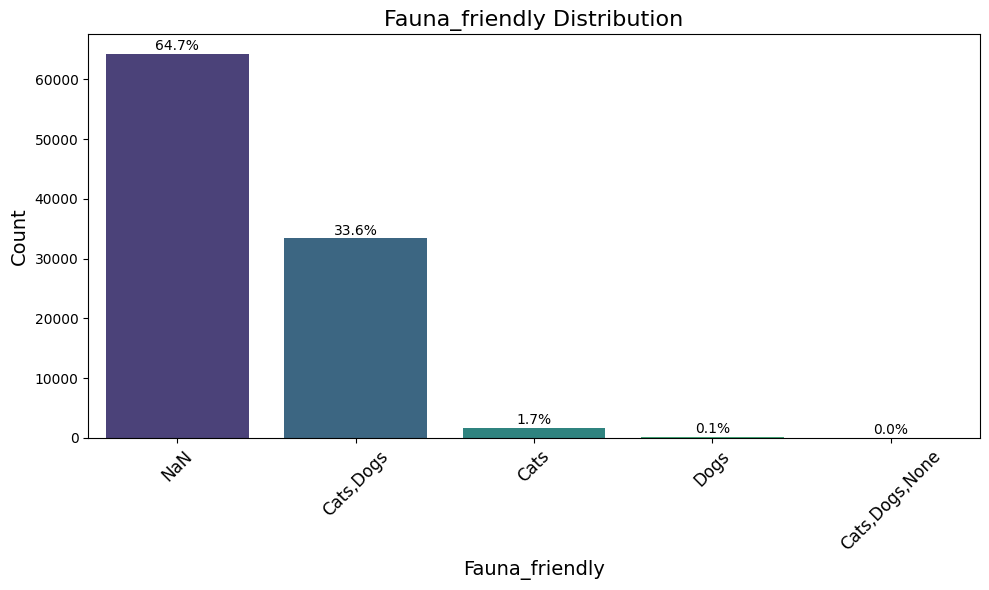

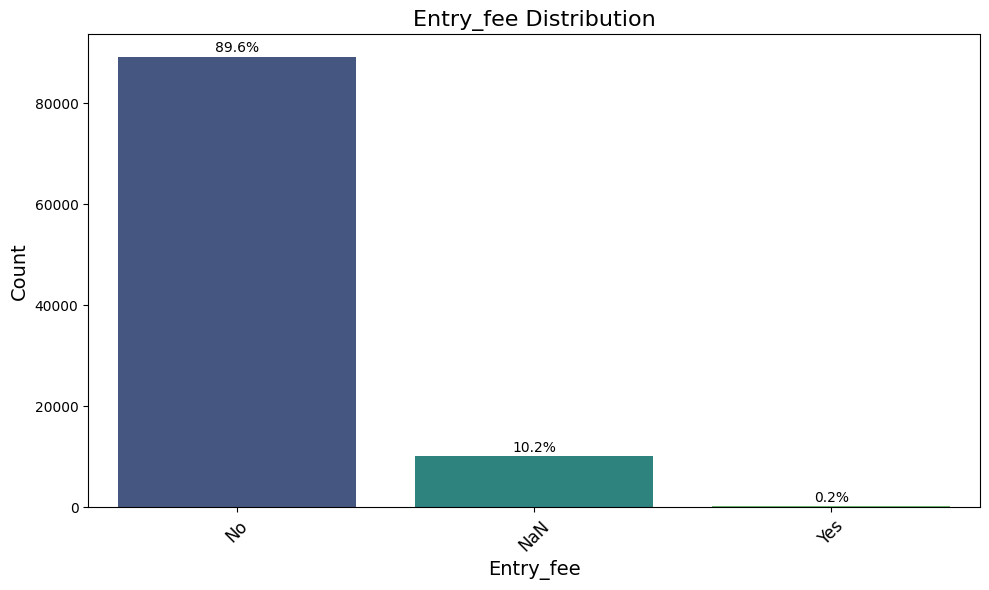

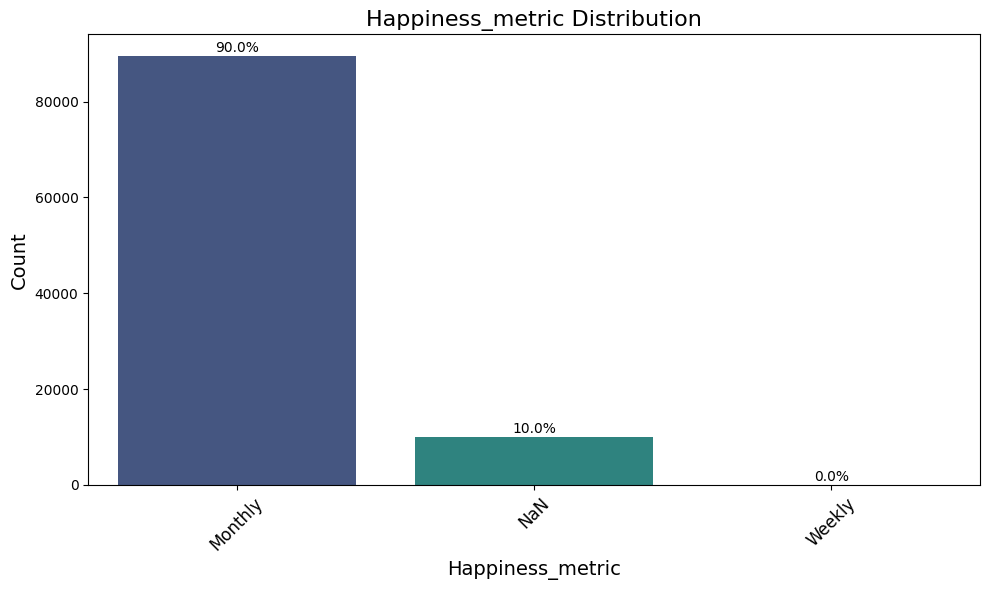

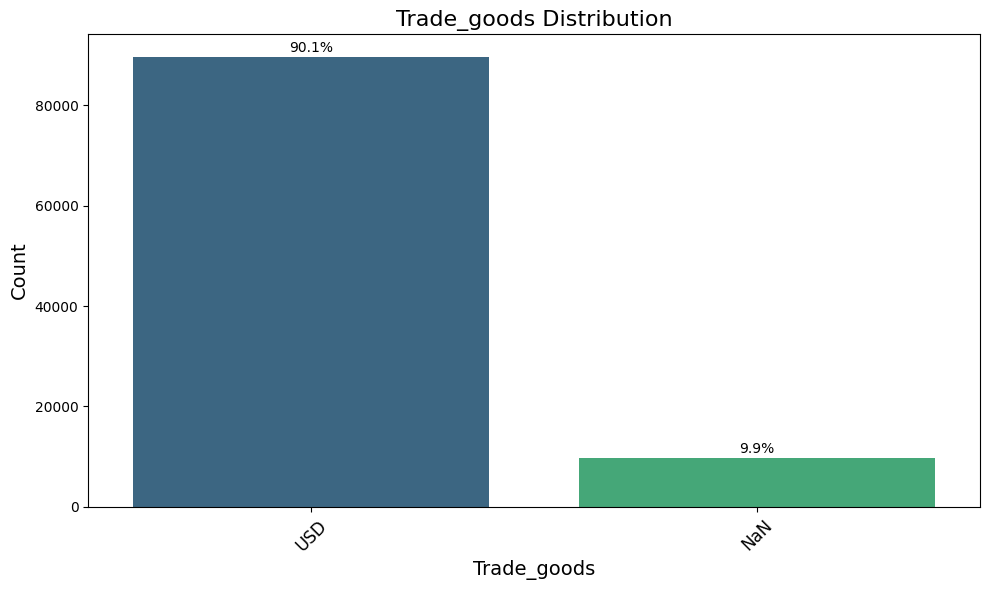

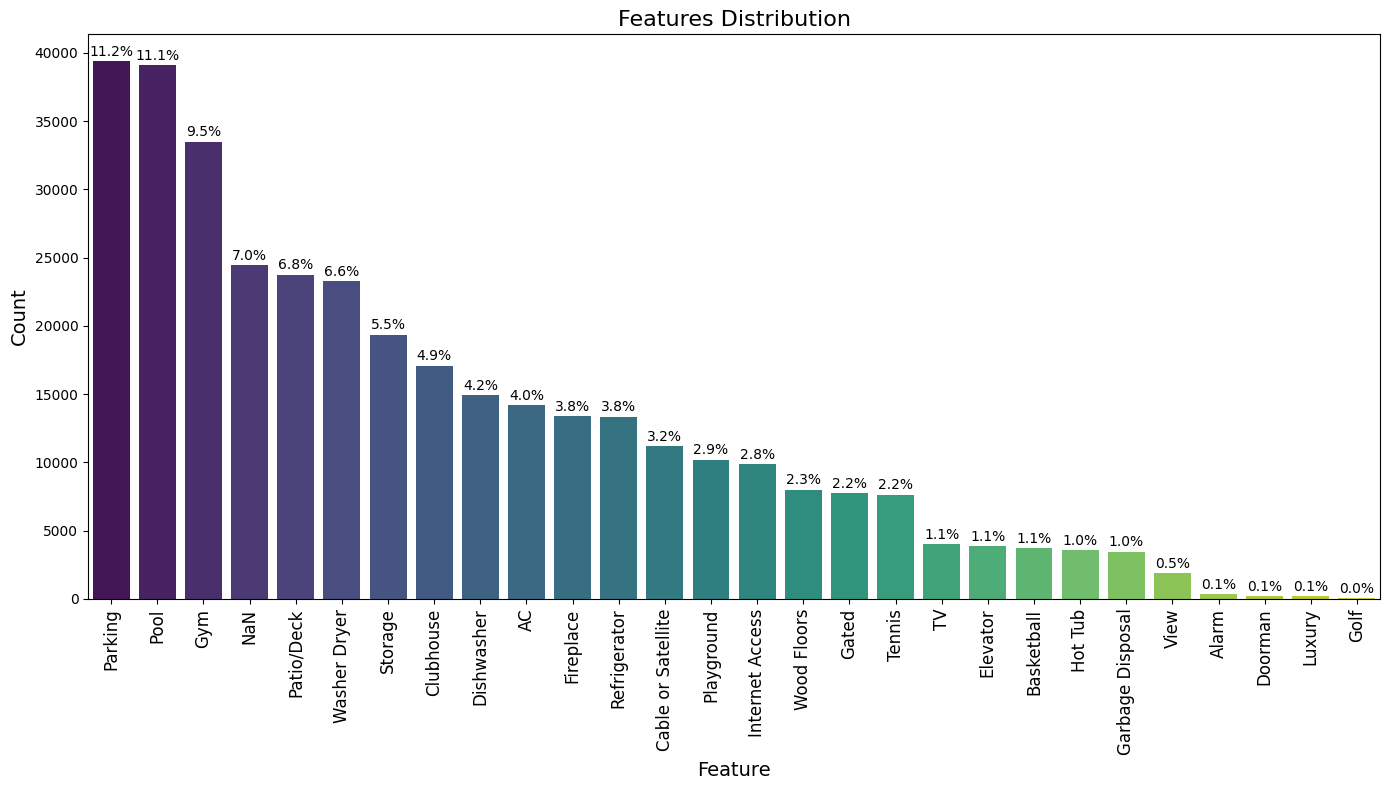

In [201]:
import seaborn as sns

# Function to plot categorical distribution
def plot_categorical_distribution(data, column, figsize=(10, 6), rotation=45):
    """
    Plots the distribution of a categorical column, including counts of 'None' (NaN) values.
    """
    # Include None/NaN counts as a separate category
    counts = data[column].fillna('NaN').value_counts()

    # Create the plot
    plt.figure(figsize=figsize)
    sns.barplot(x=counts.index, y=counts.values, hue= counts.index, palette="viridis")
    plt.xticks(rotation=rotation, fontsize=12)
    plt.title(f'{column.capitalize()} Distribution', fontsize=16)
    plt.xlabel(column.capitalize(), fontsize=14)
    plt.ylabel('Count', fontsize=14)
    
    # Add percentage labels
    for i, v in enumerate(counts.values):
        plt.text(
            i, v + max(counts.values) * 0.01,  # Slightly offset for visibility
            f"{(v / counts.sum() * 100):.1f}%",
            ha='center', fontsize=10
        )
    
    plt.tight_layout()
    plt.show()

# Function to analyze features column (list or comma-separated values)
def plot_feature_distribution(data, column, figsize=(14, 8)):
    """
    Plots the distribution of items in a column containing lists or comma-separated values.
    Handles NaN values explicitly.
    """
    # Handle missing values by replacing them with "NaN"
    features_series = data[column].fillna('NaN')

    # Split the feature strings into individual items, flatten the list
    features_split = features_series.str.split(',')
    features_flattened = [item.strip() for sublist in features_split for item in sublist]  # Trim whitespace

    # Count occurrences of each feature
    features_counts = pd.Series(features_flattened).value_counts()

    # Prepare the data for visualization
    features_df = pd.DataFrame(features_counts).reset_index()
    features_df.columns = ['Feature', 'Count']
    features_df['Percentage'] = (features_df['Count'] / features_df['Count'].sum()) * 100

    # Create the vertical barplot
    plt.figure(figsize=figsize)
    sns.barplot(x='Feature', y='Count', data=features_df, hue='Feature', palette='viridis')

    # Add percentages on top of the bars
    for index, row in features_df.iterrows():
        plt.text(
            index, row['Count'] + max(features_df['Count']) * 0.01,  # Offset based on maximum value
            f"{row['Percentage']:.1f}%",
            ha='center', fontsize=10
        )

    # Customize the plot
    plt.title('Features Distribution', fontsize=16)
    plt.xlabel('Feature', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=90, fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot categorical distributions
categorical_columns = ['region', 'fauna_friendly', 'entry_fee', 'happiness_metric', 'trade_goods']
for col in categorical_columns:
    figsize = (22, 9) if col == 'region' else (10, 6)
    plot_categorical_distribution(euphoria_data, col, figsize)

# Plot the features column distribution
plot_feature_distribution(euphoria_data, 'features')


### Exploring Numerical Variables

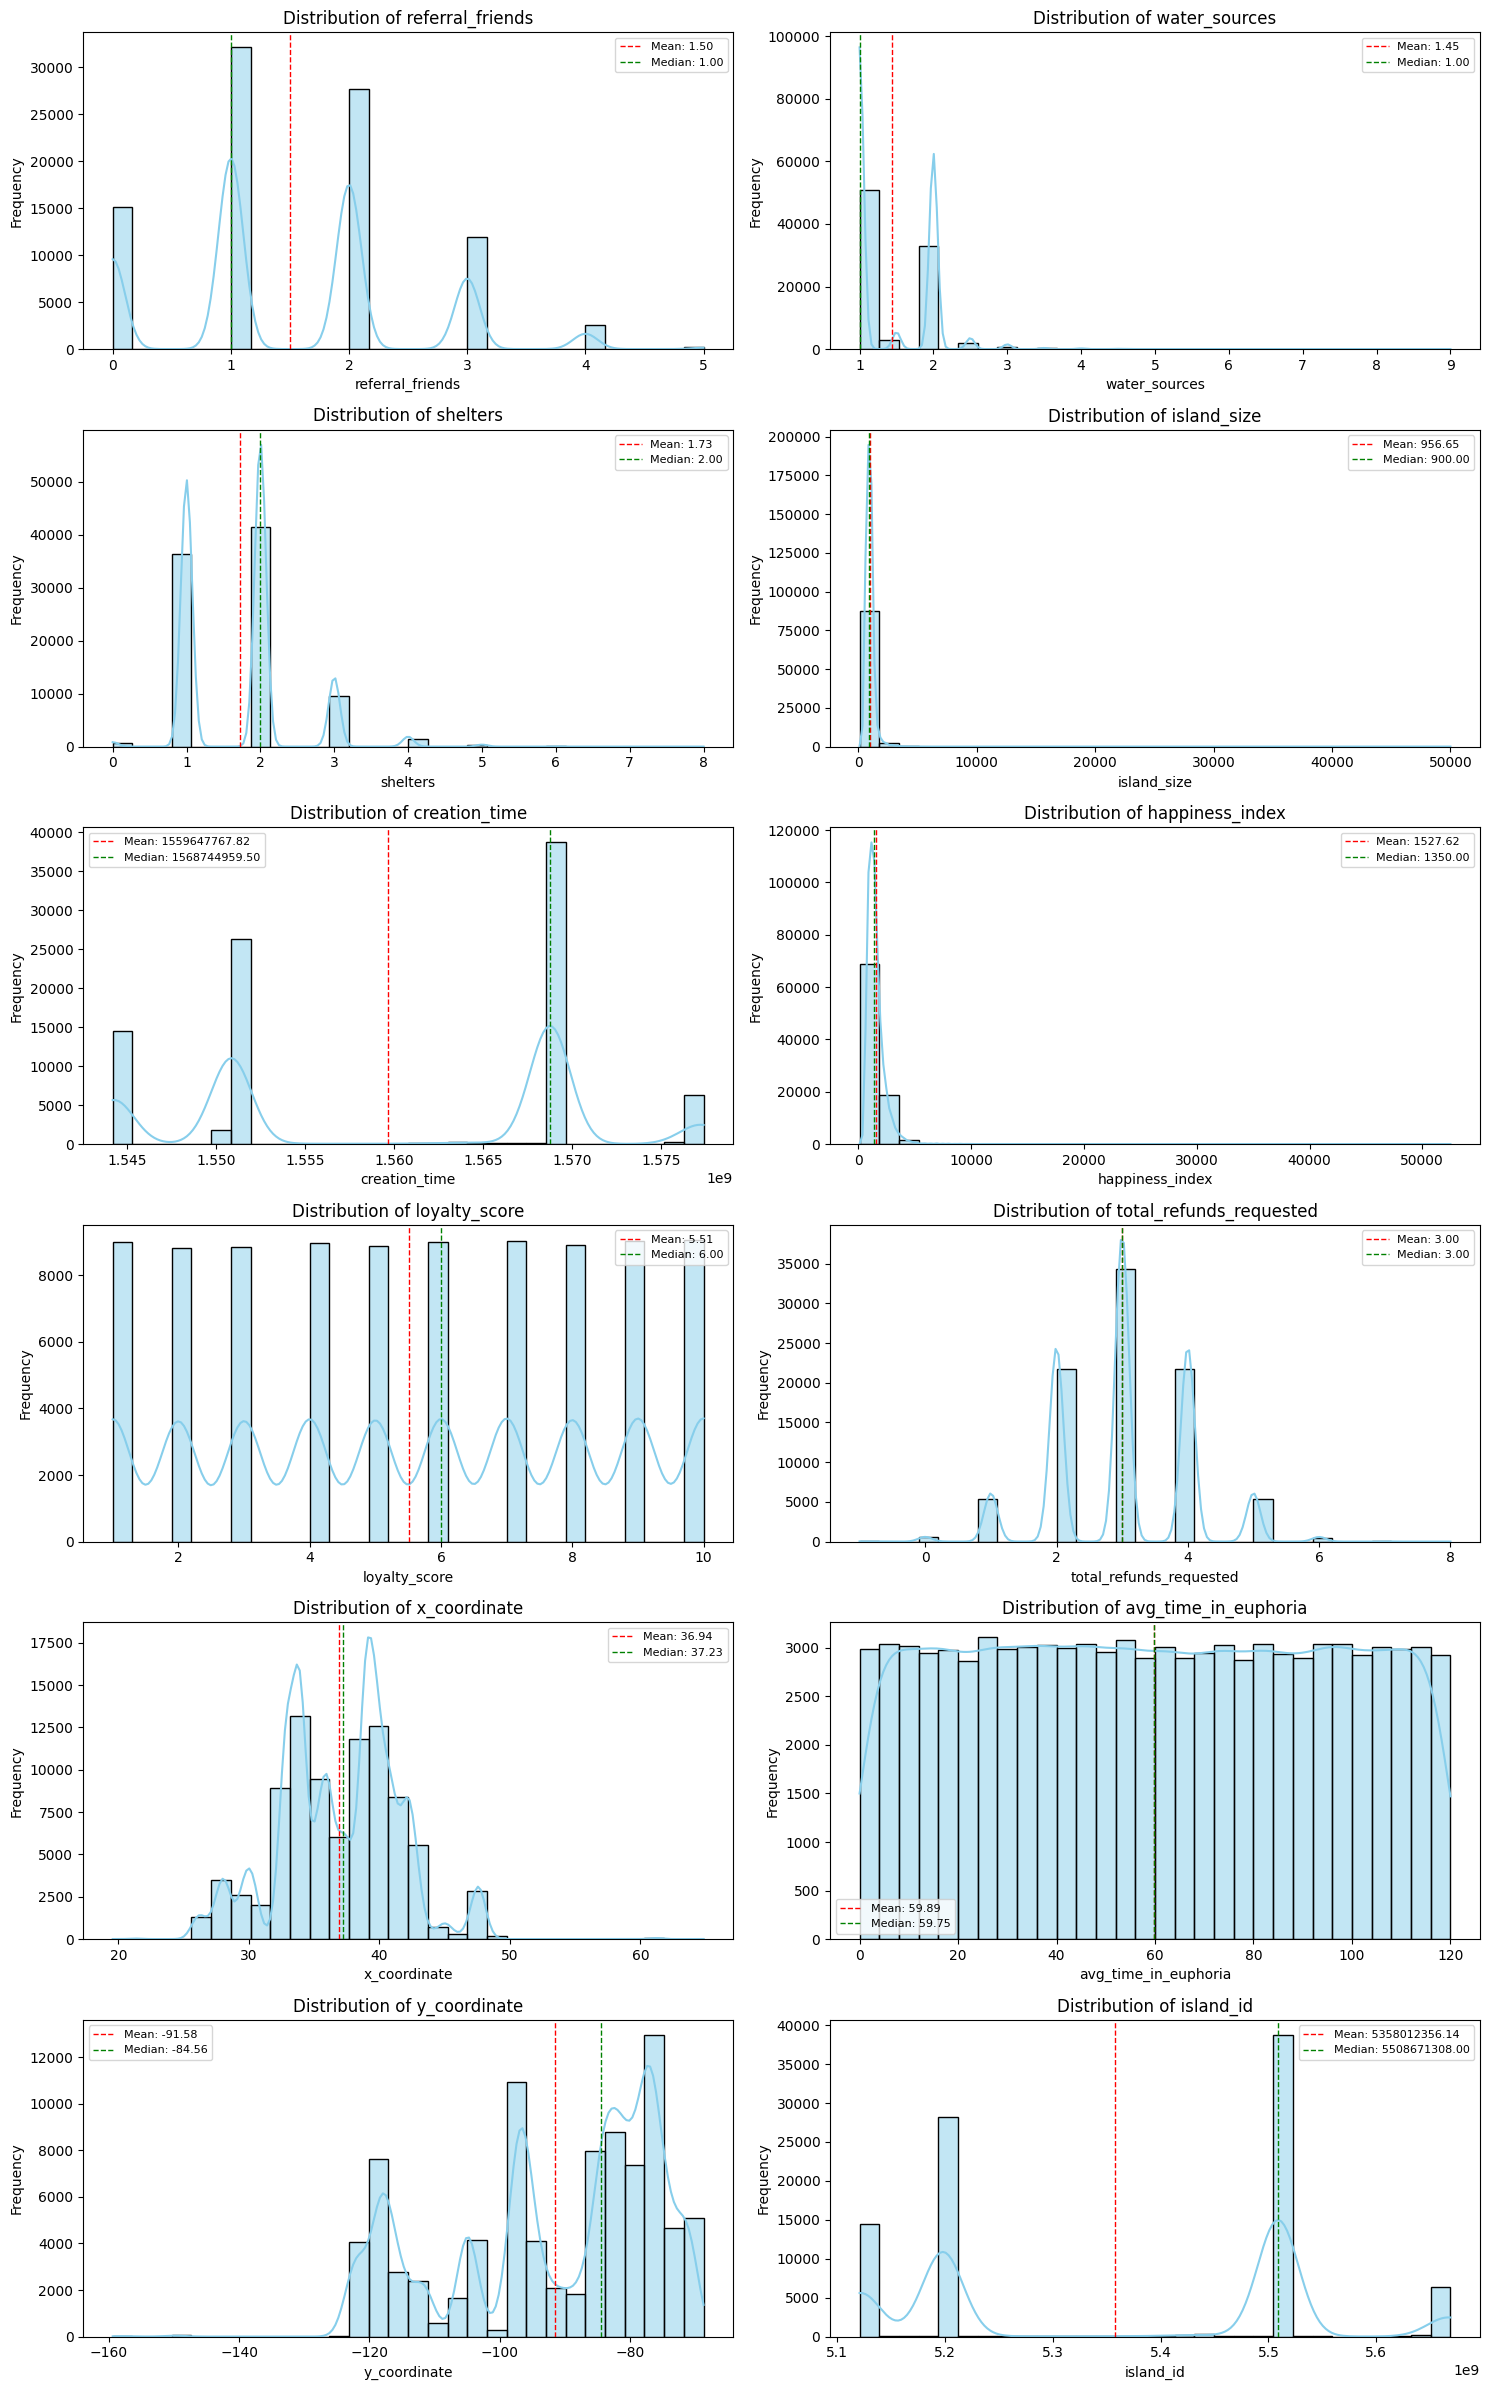

In [202]:
def plot_numeric_distributions(data, numeric_columns, bins=30):
    """
    Plots the distributions of numeric columns with KDE, including skewness and summary stats.
    
    Parameters:
    - data: DataFrame containing the data.
    - numeric_columns: List of numeric column names.
    - bins: Number of bins for the histogram.
    """
    # Calculate the grid size for subplots
    n_cols = 2
    n_rows = -(-len(numeric_columns) // n_cols)  # Ceiling division

    plt.figure(figsize=(15, n_rows * 4))  # Adjust figure height dynamically
    for i, col in enumerate(numeric_columns, 1):
        plt.subplot(n_rows, n_cols, i)
        
        # Handle missing values
        col_data = data[col].dropna()
        
        # Plot histogram with KDE
        sns.histplot(col_data, kde=True, bins=bins, color="skyblue", edgecolor="black")
        
        # Add title and labels
        plt.title(f'Distribution of {col}', fontsize=12)
        plt.xlabel(col, fontsize=10)
        plt.ylabel('Frequency', fontsize=10)
        
        # Add mean and median as vertical lines
        mean_val = col_data.mean()
        median_val = col_data.median()
        plt.axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_val:.2f}')
        plt.axvline(median_val, color='green', linestyle='--', linewidth=1, label=f'Median: {median_val:.2f}')
        plt.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

# List of numeric columns to explore
numeric_columns = euphoria_data.select_dtypes(include=['number']).columns.tolist()

# Call the function
plot_numeric_distributions(euphoria_data, numeric_columns)


## Handling Missing Values and Columns

### Handling Numerical Columns

#### **Reasons for Removing Rows with Missing `happiness_index`**

1. **Critical Importance of `happiness_index`**:
   - As the **target variable**, `happiness_index` is essential for analysis and modeling.
   - Rows with missing target values cannot be used for training or evaluation.

2. **Risk of Inaccuracy with Imputation**:
   - Imputing values for a target variable like `happiness_index` can introduce significant inaccuracies or biases, especially if the missingness is not random.

3. **Sufficient Remaining Data**:
   - With a dataset of nearly **100,000 rows**, removing around **10%** of rows (those with missing `happiness_index`) still leaves a large dataset, ensuring sufficient data for accurate analysis and modeling.

4. **Avoiding Noise and Complexity**:
   - Rows with missing `happiness_index` add noise and unnecessary complexity to the dataset, potentially lowering the quality of analysis and model performance.

5. **Simplified Preprocessing**:
   - By removing these rows, the preprocessing pipeline is simpler and ensures the integrity of the dataset for downstream tasks.


In [203]:
# Check the number of rows before removal
print(f"Number of rows before removal: {euphoria_data.shape[0]}")

# Remove rows where 'happiness_index' is missing
euphoria_data = euphoria_data.dropna(subset=['happiness_index'])

# Check the number of rows after removal
print(f"Number of rows after removal: {euphoria_data.shape[0]}")


Number of rows before removal: 99492
Number of rows after removal: 89455


#### **Reasons to Remove `island_id`**
1. **Missing Values**:
   - `island_id` has 10% missing values, which makes it unreliable as a unique identifier.

2. **Irrelevance to Analysis**:
   - The `island_id` column serves as an identifier and doesn't contribute meaningful information for analysis or modeling.

3. **Row Index as Identifier**:
   - The row index can serve as a unique identifier without the need for `island_id`, since each row in our dataset represents a unique entry.

By removing `island_id` and using the row index, we simplify the dataset while preserving the ability to uniquely identify each entry. 

In [204]:
if 'island_id' in euphoria_data.columns:
    # Exclude rows where 'island_id' is NaN
    non_missing_ids = euphoria_data[~euphoria_data['island_id'].isna()]
    
    # Identify duplicate rows based on non-missing 'island_id'
    duplicate_ids = non_missing_ids[non_missing_ids['island_id'].duplicated(keep=False)]
    
    print(f"Total duplicate rows with non-missing 'island_id': {len(duplicate_ids)}")
    print(duplicate_ids.head())  # Display a sample of duplicate rows
    
    # Drop all rows where 'island_id' is duplicated
    euphoria_data = euphoria_data[~euphoria_data['island_id'].isin(duplicate_ids['island_id'])]
    print(f"Dataset after removing all duplicate IDs: {euphoria_data.shape}")
else:
    print("'island_id' column does not exist in the dataset.")

# Remove the 'island_id' column
if 'island_id' in euphoria_data.columns:
    euphoria_data.drop(columns=['island_id'], inplace=True)
    print("'island_id' column has been removed.")
else:
    print("'island_id' column does not exist in the dataset.")

# Ensure the row index is unique
if not euphoria_data.index.is_unique:
    euphoria_data.reset_index(drop=True, inplace=True)
    print("Row index has been reset to ensure uniqueness.")

# Confirm the new structure
print(f"Dataset shape: {euphoria_data.shape}")
print("Row index is now used as the unique identifier.")



Total duplicate rows with non-missing 'island_id': 116
      referral_friends  water_sources  shelters fauna_friendly  island_size  creation_time region happiness_metric                                                                           features  happiness_index  loyalty_score  total_refunds_requested trade_goods  x_coordinate  avg_time_in_euphoria  y_coordinate     island_id entry_fee nearest_city
277                2.0            1.0       3.0      Cats,Dogs        983.0   1.550813e+09     TN          Monthly                                                                                NaN           1489.0            8.0                      2.0         USD       35.1478                 70.04      -90.0521  5.197679e+09        No      Memphis
434                1.0            2.0       2.0            NaN       1376.0   1.568754e+09     OH          Monthly                                                                            Parking           2205.0           10.0        

#### Filling Missing Values of water_sources, shelters, island_size, loyalty_score, total_refunds_requested, avg_time_in_euphoria

In [205]:
# Handle missing values for numeric columns by imputing with the median and mean
numeric_cols_with_missing = ['loyalty_score', 'total_refunds_requested', 'avg_time_in_euphoria', 'shelters', 'island_size', 'water_sources']

for col in numeric_cols_with_missing:
    # Fill missing values with the median for skewed columns
    if col in ['shelters', 'island_size', 'water_sources']:
        median_value = euphoria_data[col].median()
        euphoria_data[col] = euphoria_data[col].fillna(median_value)
    else:
        mean_value = euphoria_data[col].mean()
        euphoria_data[col] = euphoria_data[col].fillna(mean_value)

#### Determining which columns to remove and which one to use

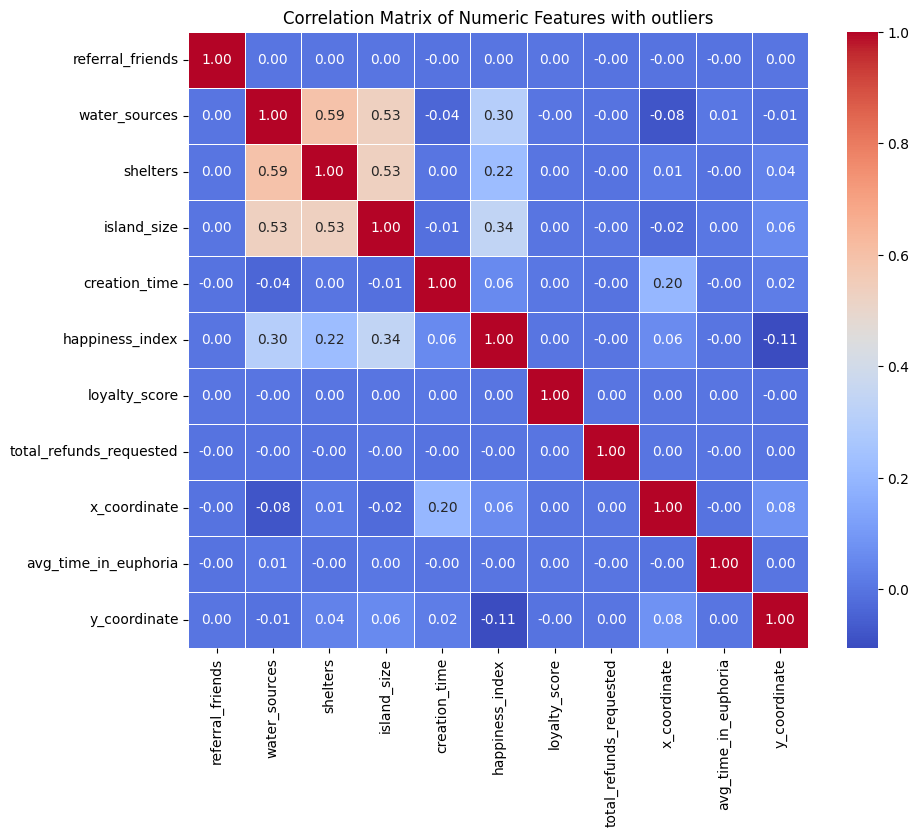

In [206]:
numeric_columns = euphoria_data.select_dtypes(include=['number']).columns.tolist()

# Compute correlation matrix for numeric columns
correlation_matrix = euphoria_data[numeric_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features with outliers')
plt.show()

#### **Reasons for Removing the Columns** `referral_friends`, `x_coordinate`, `y_coordinate`, and `creation_time`

1. **No Significant Correlation with `happiness_index`**:
   - All the columns have negligible correlations with the target variable (`happiness_index`), ranging from **0.00** to very weak correlations like **0.06** or **-0.11**.

2. **No Significant Correlation with Other Features**:
   - Most columns show near-zero correlation with other features, making them redundant in the dataset.

3. **Low Predictive Utility**:
   - Due to the lack of meaningful relationships with the target and other features, these columns are unlikely to contribute useful information for analysis or modeling.

4. **Dataset Simplification**:
   - Removing these uninformative columns helps simplify the dataset, reducing dimensionality and potential noise, improving interpretability and model performance.

In [207]:
columns_to_remove = ['referral_friends', 'x_coordinate', 'y_coordinate', 'creation_time']

# Ensure the columns exist in the dataset before dropping
existing_columns_to_remove = [col for col in columns_to_remove if col in euphoria_data.columns]

if existing_columns_to_remove:
    euphoria_data.drop(columns=existing_columns_to_remove, inplace=True)
    print(f"Columns removed: {existing_columns_to_remove}")
    print(f"Updated dataset shape: {euphoria_data.shape}")
else:
    print("No columns to remove.")

Columns removed: ['referral_friends', 'x_coordinate', 'y_coordinate', 'creation_time']
Updated dataset shape: (89339, 14)


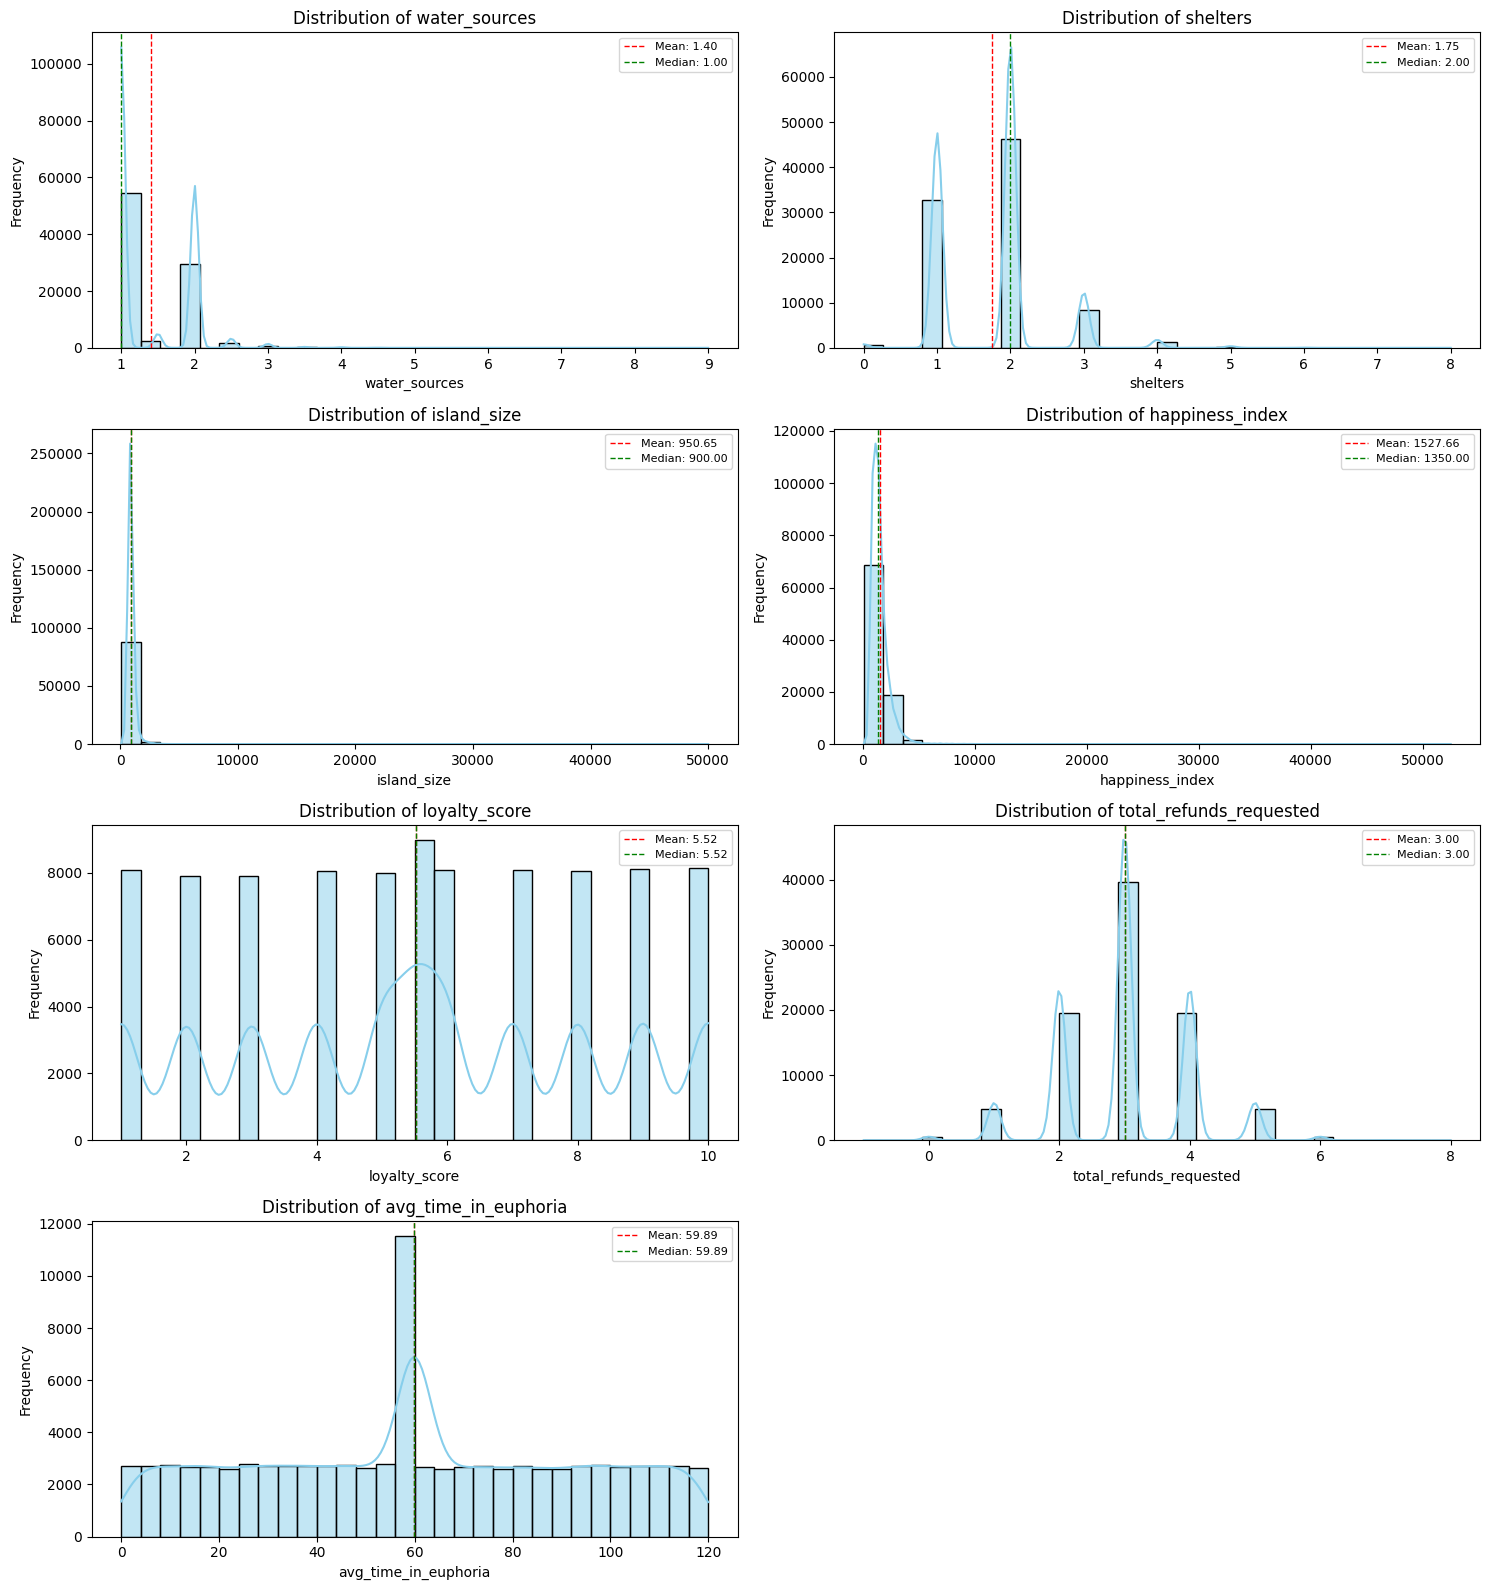

In [208]:
numeric_columns = euphoria_data.select_dtypes(include=['number']).columns.tolist()
plot_numeric_distributions(euphoria_data, numeric_columns)

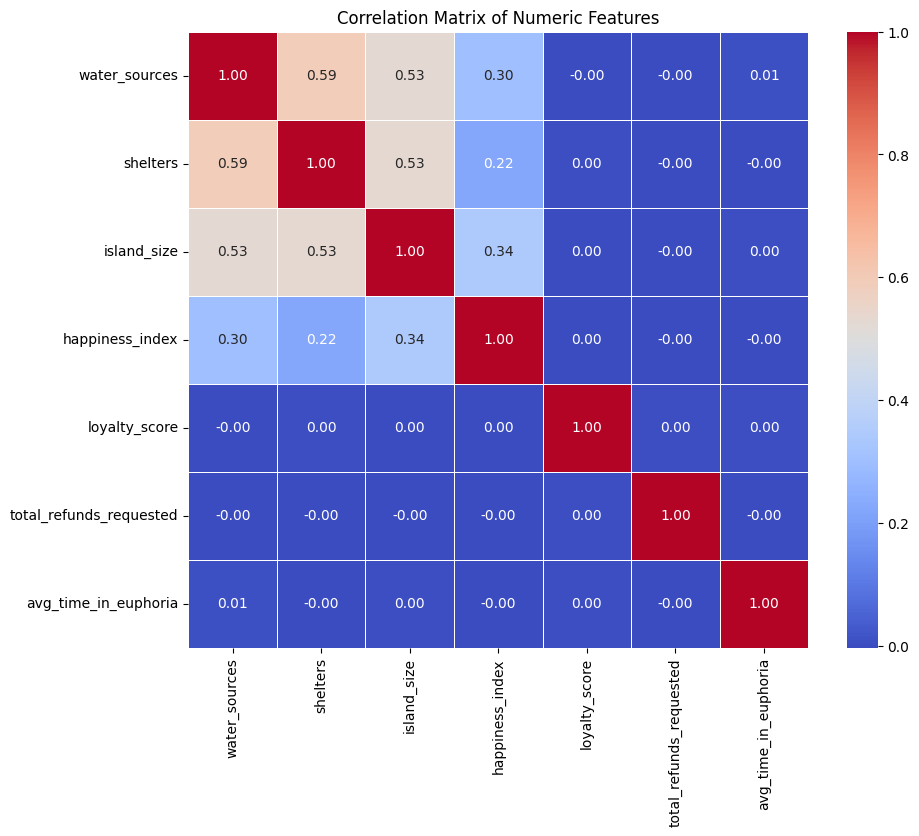

In [209]:
# Compute correlation matrix for numeric columns
correlation_matrix = euphoria_data[numeric_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()


### Handling Categorical Columns

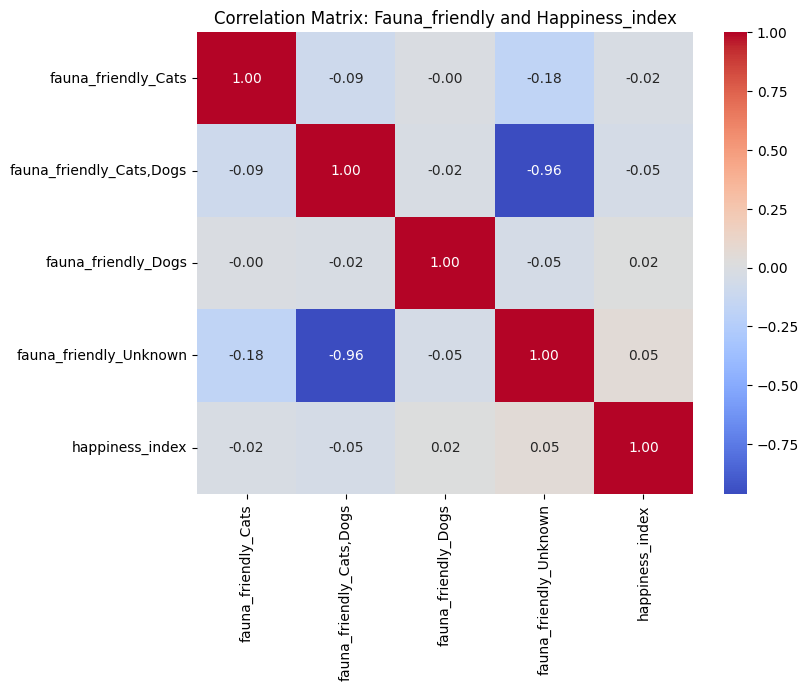

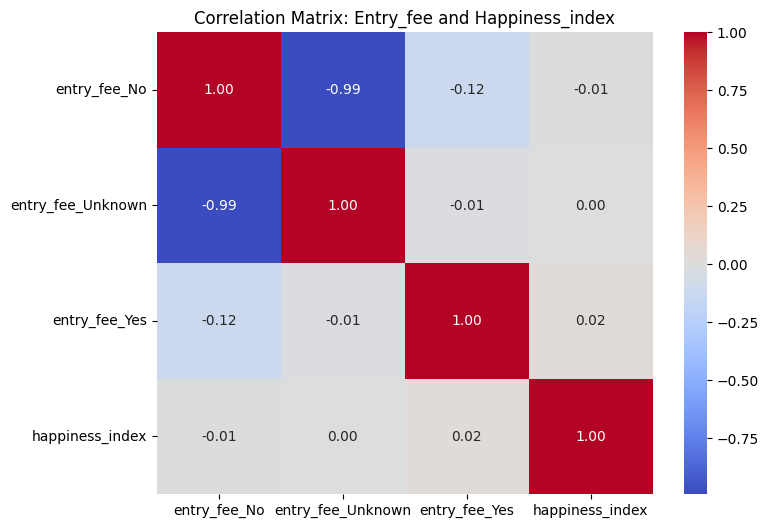

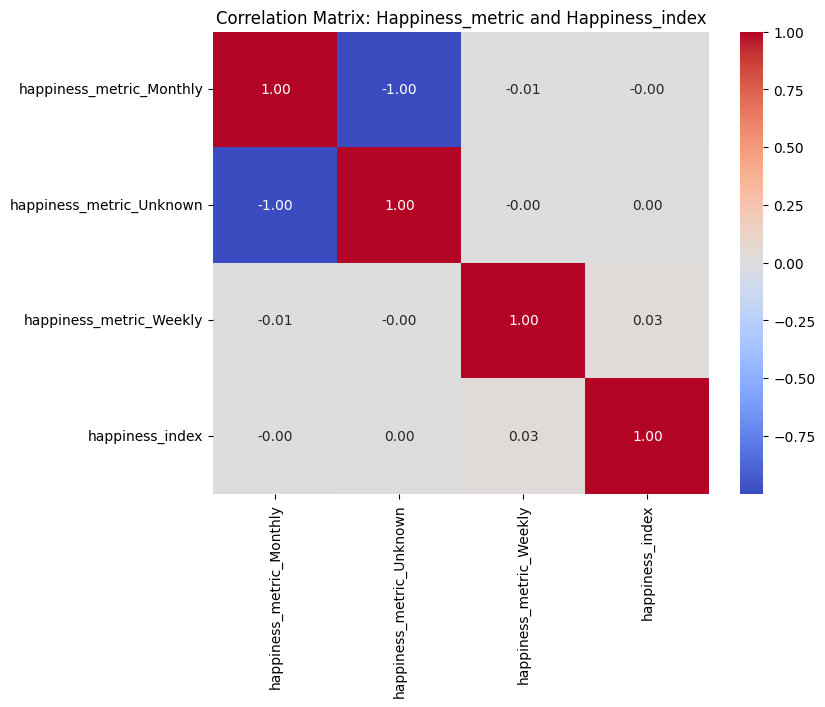

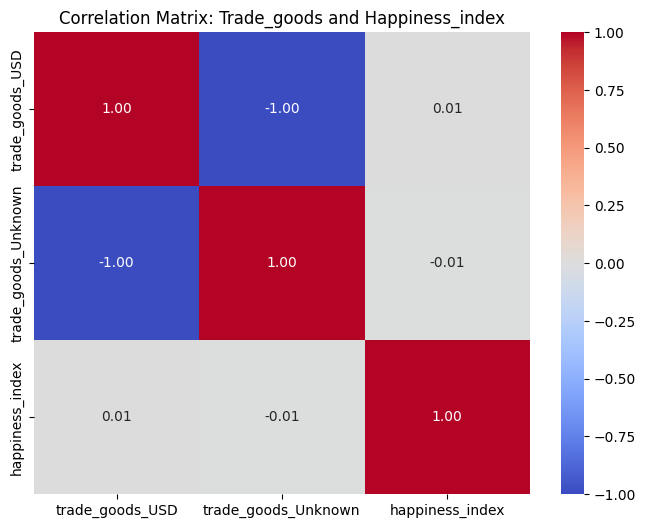

In [210]:
def analyze_categorical_correlation(data, categorical_columns, target_column):
    for col in categorical_columns:
        if col in data.columns:
            # Encode the categorical column, including 'None', as binary categories
            data[col] = data[col].fillna('Unknown')
            data = pd.get_dummies(data, columns=[col], drop_first=False)

            # Filter the correlation matrix to include only the categorical-related columns and target_column
            categorical_columns_encoded = [encoded_col for encoded_col in data.columns if f'{col}_' in encoded_col]
            selected_columns = categorical_columns_encoded + [target_column]

            # Calculate correlation matrix for selected columns
            correlation_matrix = data[selected_columns].corr()

            # Visualize the correlation matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
            plt.title(f'Correlation Matrix: {col.capitalize()} and {target_column.capitalize()}')
            plt.show()

euphoria_data['fauna_friendly'] = euphoria_data['fauna_friendly'].replace('Cats,Dogs,None', 'Cats,Dogs')
categorical_columns = ['fauna_friendly', 'entry_fee', 'happiness_metric', 'trade_goods']
analyze_categorical_correlation(euphoria_data, categorical_columns, 'happiness_index')

#### **Reasons for Removing `entry_fee`, `happiness_metric`, `trade_goods`, and `fauna_friendly`:**

1. **No Significant Correlation**:
   - None of these columns show meaningful correlation with the target variable (`happiness_index`), as all correlation values are negligible.

2. **Extreme Imbalance**:
   - Each column is dominated by a single category, with minimal representation in other categories:
     - **`entry_fee`**: `No` (89.6%), `None` (10.2%), `Yes` (0.2%).
     - **`happiness_metric`**: `Monthly` (90%), `None` (10%), `Weekly` (0%).
     - **`trade_goods`**: `USD` (90%), `None` (10%).
     - **`fauna_friendly`**: `NaN` (64.7%), `Cats,Dogs` (33.6%), with other categories accounting for less than 2%.

3. **High Missing Values** (Specific to `fauna_friendly`):
   - The `fauna_friendly` column contains 64.7% missing values, making it unreliable and unsuitable for analysis.

4. **Low Predictive Utility**:
   - The lack of variability and negligible correlation in these columns indicates they are unlikely to contribute to predictive modeling or provide meaningful insights.


The columns `entry_fee`, `happiness_metric`, `trade_goods`, and `fauna_friendly` are removed to simplify the dataset, reduce noise, and focus on features that offer greater analytical or predictive value.

In [211]:
columns_to_remove = ['fauna_friendly', 'entry_fee', 'happiness_metric', 'trade_goods', 'nearest_city']

# Ensure the columns exist in the dataset before dropping
existing_columns_to_remove = [col for col in columns_to_remove if col in euphoria_data.columns]

if existing_columns_to_remove:
    euphoria_data.drop(columns=existing_columns_to_remove, inplace=True)
    print(f"Columns removed: {existing_columns_to_remove}")
    print(f"Updated dataset shape: {euphoria_data.shape}")
else:
    print("No columns to remove.")

Columns removed: ['fauna_friendly', 'entry_fee', 'happiness_metric', 'trade_goods', 'nearest_city']
Updated dataset shape: (89339, 9)


#### Analyzing `region` Column

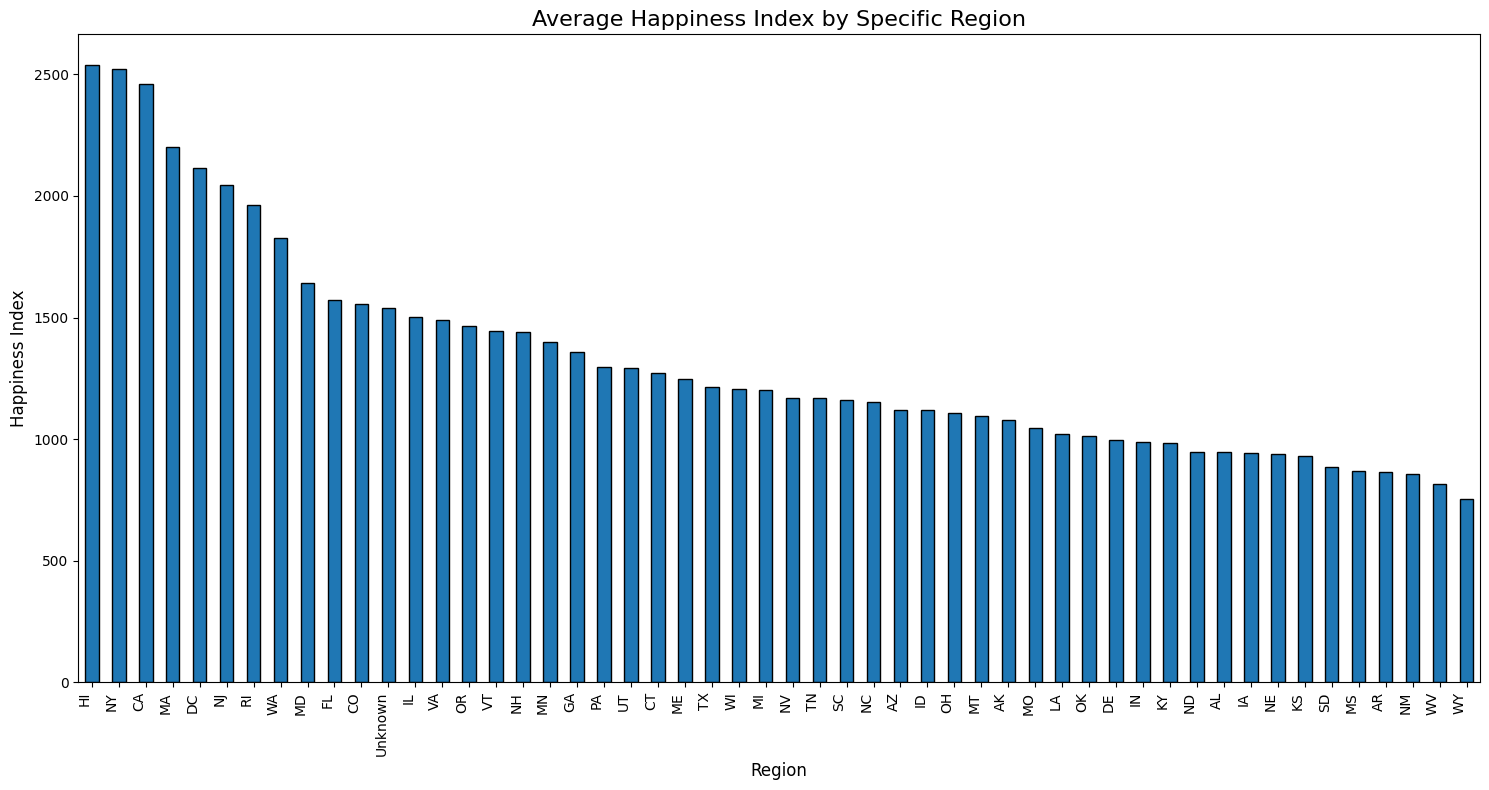

In [212]:
# Handle missing values in 'region' by imputing with 'Unknown'
euphoria_data['region'] = euphoria_data['region'].fillna('Unknown')

# Compute average happiness index for each specific region
region_happiness = (
    euphoria_data.groupby('region')['happiness_index']
    .mean()
    .sort_values(ascending=False)
)

# Plot average happiness index by specific region
plt.figure(figsize=(15, 8))
region_happiness.plot(kind='bar', edgecolor='black')
plt.title('Average Happiness Index by Specific Region', fontsize=16)
plt.ylabel('Happiness Index', fontsize=12)
plt.xlabel('Region', fontsize=12)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


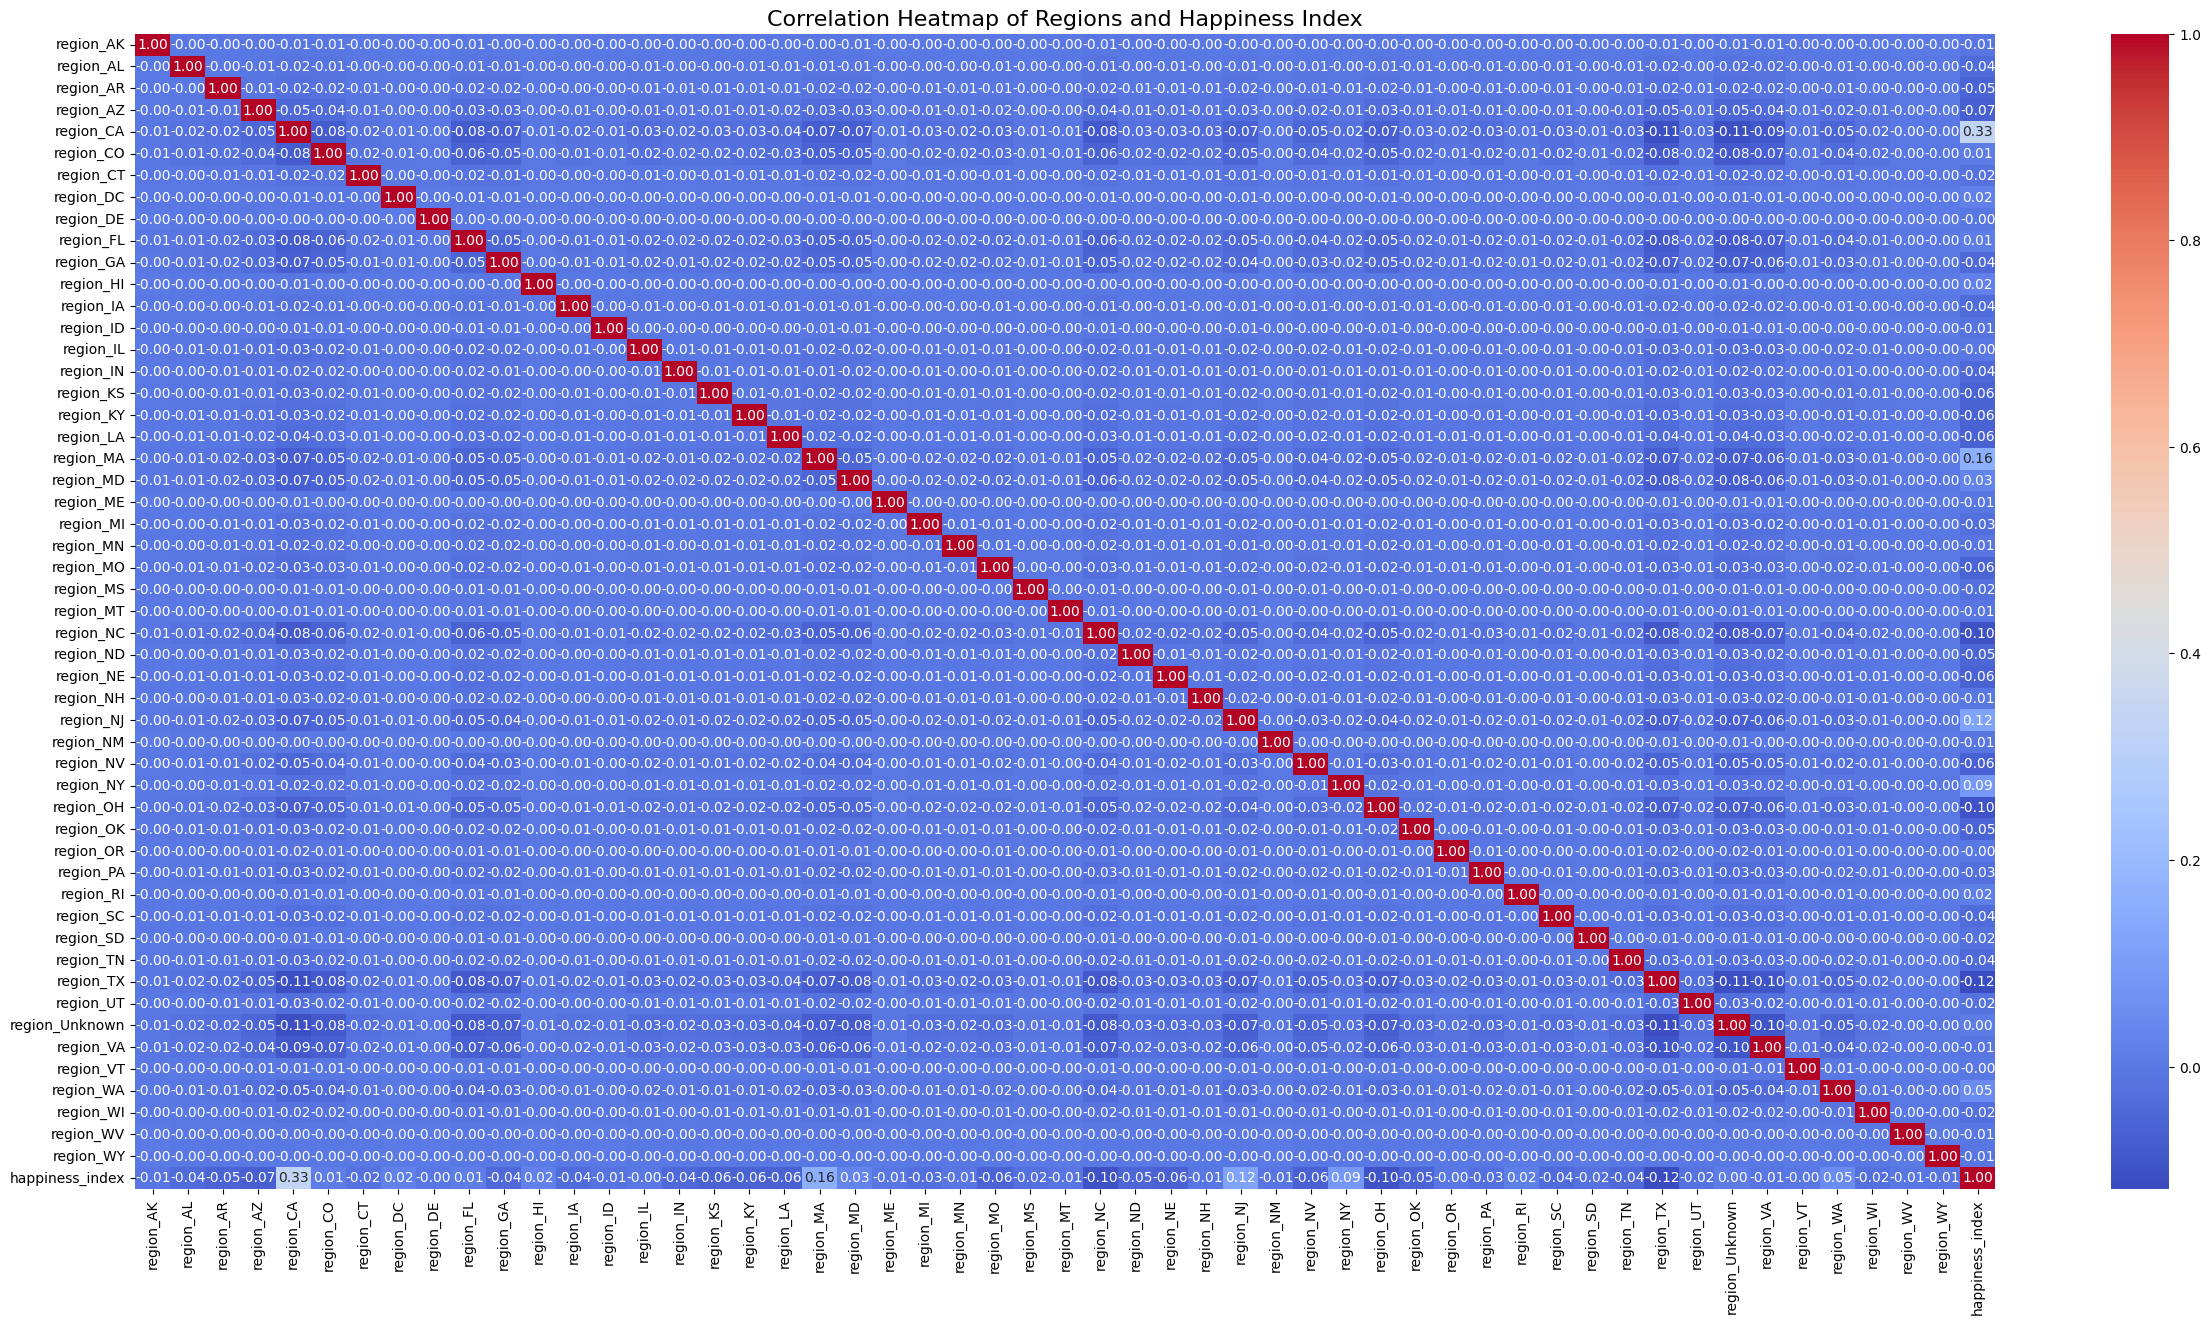

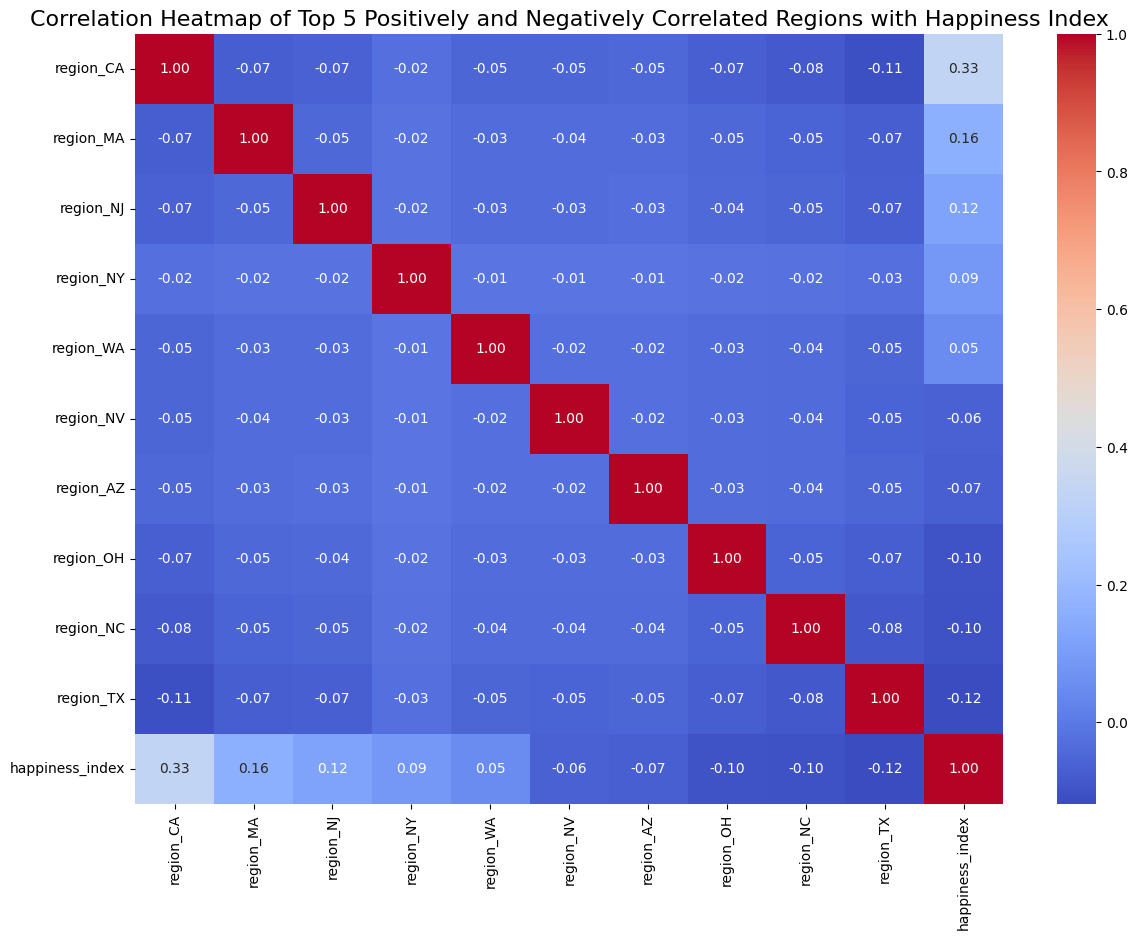

In [213]:
# Handle missing values in 'region' by imputing with 'Unknown' and one-hot encode it
euphoria_data['region'] = euphoria_data['region'].fillna('Unknown')
region_encoded = pd.get_dummies(euphoria_data['region'], prefix='region')

# Concatenate one-hot encoded regions with 'happiness_index'
region_happiness_data = pd.concat([region_encoded, euphoria_data['happiness_index']], axis=1)

# Compute and plot the correlation matrix
plt.figure(figsize=(30, 15))
sns.heatmap(region_happiness_data.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Correlation Heatmap of Regions and Happiness Index', fontsize=16)
plt.show()

# Calculate correlations with 'happiness_index'
region_correlations = region_happiness_data.corr()['happiness_index'].sort_values(ascending=False)

# Exclude 'happiness_index' itself
region_correlations = region_correlations.drop('happiness_index')

# Select top 5 positively and negatively correlated regions
top_positive = region_correlations.head(5)
top_negative = region_correlations.tail(5)

# Combine the top correlated regions
selected_regions = pd.concat([top_positive, top_negative])

# Plot the heatmap for the top 5 positively and negatively correlated regions
selected_region_happiness_data = region_happiness_data[selected_regions.index.tolist() + ['happiness_index']]
plt.figure(figsize=(14, 10))
sns.heatmap(selected_region_happiness_data.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Correlation Heatmap of Top 5 Positively and Negatively Correlated Regions with Happiness Index', fontsize=16)
plt.show()

#### Encoding region column in groups

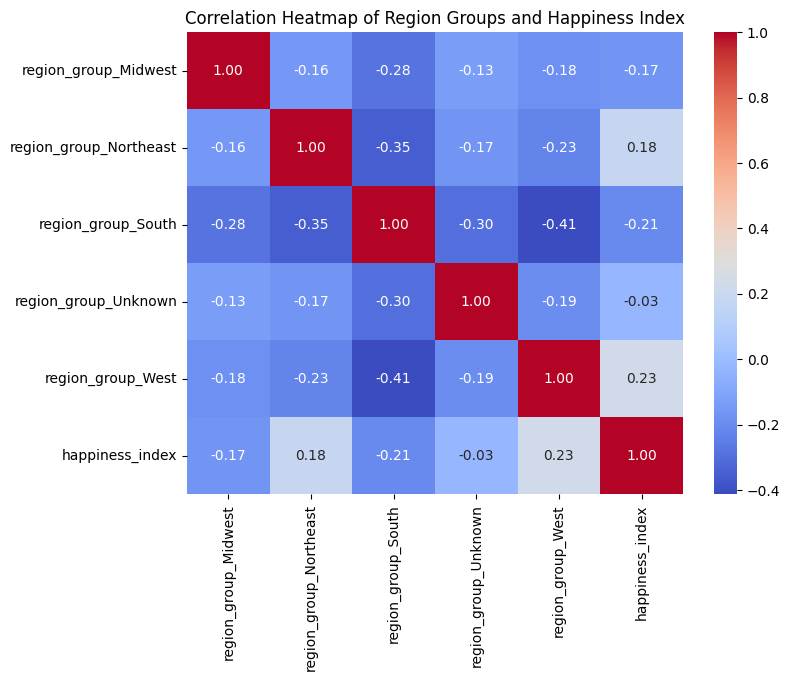

Region Group Encoding Summary:
region_group_Unknown    10973
dtype: int64


In [214]:
# Define region groupings
region_groups = {
    'West': ['CA', 'WA', 'OR', 'NV', 'UT', 'AK', 'HI', 'ID', 'MT', 'WY', 'CO'],
    'Midwest': ['IL', 'OH', 'MI', 'MO', 'IA', 'ND', 'SD', 'NE', 'KS', 'MN', 'WI', 'IN'],
    'South': ['TX', 'FL', 'GA', 'SC', 'NC', 'VA', 'WV', 'TN', 'AL', 'KY', 'MS', 'AR', 'LA', 'OK'],
    'Northeast': ['NY', 'PA', 'MA', 'NJ', 'CT', 'RI', 'NH', 'VT', 'ME', 'DE', 'MD', 'DC']
}

# Map regions to broader categories
euphoria_data['region_group'] = euphoria_data['region'].map(
    lambda x: next((k for k, v in region_groups.items() if x in v), 'Unknown')
)

# One-hot encode grouped regions directly into `euphoria_data`
region_group_encoded = pd.get_dummies(euphoria_data['region_group'], prefix='region_group')
euphoria_data = pd.concat([euphoria_data, region_group_encoded], axis=1)

# Re-run correlation analysis with happiness_index
group_happiness_data = pd.concat([region_group_encoded, euphoria_data['happiness_index']], axis=1)

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(group_happiness_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Region Groups and Happiness Index')
plt.show()

# Confirm `Unknown` group is included and visible
print("Region Group Encoding Summary:")
print(euphoria_data[['region_group_Unknown']].sum())

#### Dropping region and region_group column

In [215]:
# Check and drop the 'features' and 'num_features' columns if they exist
columns_to_remove = ['region', 'region_group']

# Filter for columns that exist in the DataFrame
columns_to_drop = [col for col in columns_to_remove if col in euphoria_data.columns]

if columns_to_drop:
    euphoria_data.drop(columns=columns_to_drop, inplace=True)
    print(f"Removed columns: {columns_to_drop}")
    print(f"Updated dataset shape: {euphoria_data.shape}")
else:
    print("No specified columns found to remove.")

Removed columns: ['region', 'region_group']
Updated dataset shape: (89339, 13)


#### Analyzing `features` column

Total unique amenities: 28
Top Correlated Amenities:
Elevator              0.090450
Wood Floors           0.079719
Doorman               0.066753
View                  0.049253
TV                    0.018793
Unknown               0.017762
Hot Tub               0.016165
Parking               0.011195
Gated                 0.010107
Gym                   0.008169
Luxury                0.007320
Alarm                 0.005956
Patio/Deck            0.001542
Golf                 -0.000135
Fireplace            -0.016194
Storage              -0.022584
Pool                 -0.026195
Internet Access      -0.027376
Basketball           -0.032770
Tennis               -0.036237
AC                   -0.037618
Washer Dryer         -0.044353
Dishwasher           -0.048390
Cable or Satellite   -0.052846
Refrigerator         -0.057064
Clubhouse            -0.063355
Garbage Disposal     -0.065233
Playground           -0.103377
Name: happiness_index, dtype: float64


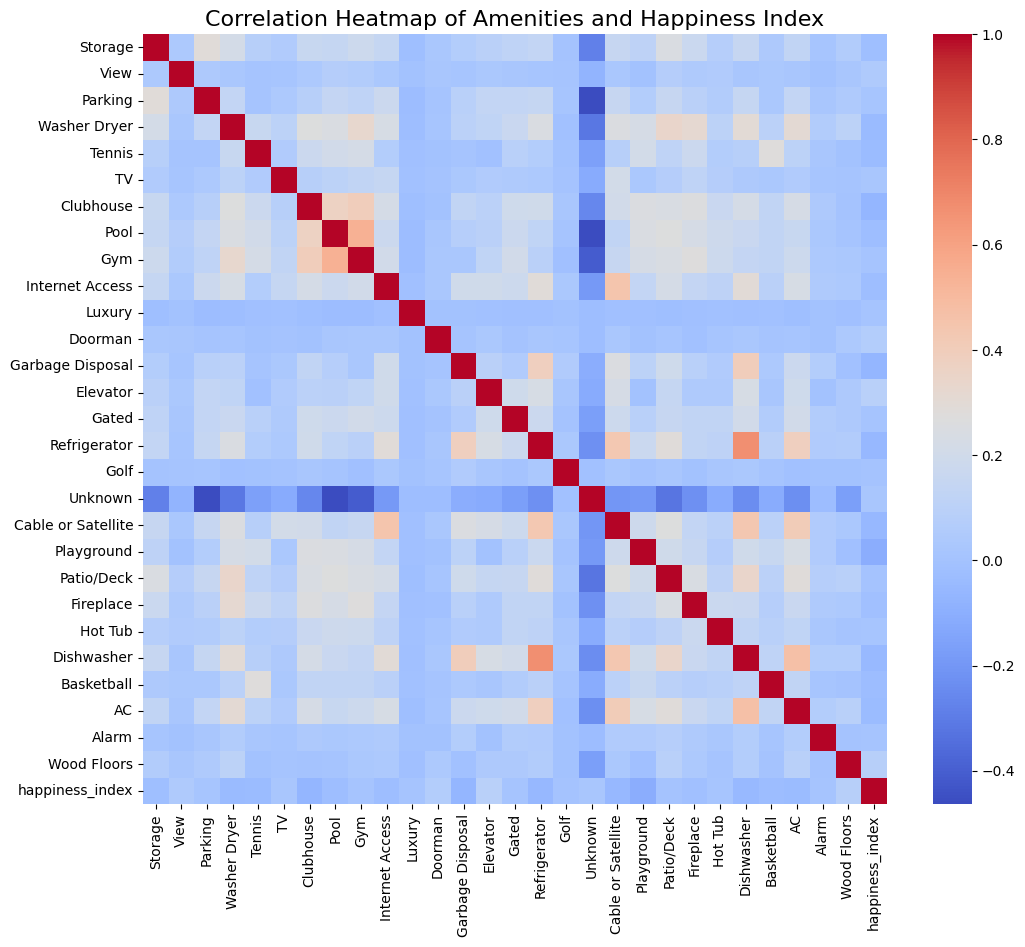

In [216]:
# Step 1: Split the 'features' column into individual amenities
euphoria_data['features'] = euphoria_data['features'].fillna('Unknown')
euphoria_features = euphoria_data.copy()
euphoria_features['features_split'] = euphoria_features['features'].fillna('').str.split(',')

# Step 2: Extract unique amenities
unique_amenities = set(amenity.strip() for sublist in euphoria_features['features_split'] for amenity in sublist)
print(f"Total unique amenities: {len(unique_amenities)}")  # Number of unique amenities

# Step 3: Create binary columns for each unique amenity
# Using a vectorized approach for improved performance
for amenity in unique_amenities:
    euphoria_features[amenity] = euphoria_features['features_split'].apply(lambda x: 1 if amenity in x else 0)

# Step 4: Drop intermediate 'features_split' column (optional)
euphoria_features = euphoria_features.drop(columns=['features_split'])

# Step 5: Compute correlation matrix with happiness_index
amenity_columns = list(unique_amenities)  # List of one-hot encoded amenity columns
correlation_with_happiness = (
    euphoria_features[amenity_columns + ['happiness_index']]
    .corr()['happiness_index']
    .drop('happiness_index')
    .sort_values(ascending=False)
)

# Display top correlated amenities
print("Top Correlated Amenities:")
print(correlation_with_happiness)

# Step 7: Visualize the heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(
    euphoria_features[amenity_columns + ['happiness_index']].corr(),
    cmap='coolwarm',
    annot=False,
    cbar=True
)
plt.title('Correlation Heatmap of Amenities and Happiness Index', fontsize=16)
plt.show()


##### Analyzing features column based on the `number of features`

In [217]:
# Ensure the 'features' column is filled with empty strings for missing values
euphoria_data['features'] = euphoria_data['features'].fillna('')

# Create the 'num_features' column by counting the number of amenities in each row
euphoria_data['num_features'] = euphoria_data['features'].apply(lambda x: len(x.split(',')) if x else 0)

# Display the first few rows to confirm the addition of 'num_features'
print(euphoria_data[['features', 'num_features']].head())

# Check basic statistics of the new column
print(euphoria_data['num_features'].describe())

                                                                                            features  num_features
0                                  AC,Clubhouse,Fireplace,Parking,Patio/Deck,Playground,Pool,Storage             8
1                                                                                            Parking             1
2  AC,Cable or Satellite,Clubhouse,Dishwasher,Fireplace,Gated,Gym,Parking,Patio/Deck,Refrigerator,TV            11
3                                                  AC,Dishwasher,Fireplace,Gated,Gym,Patio/Deck,Pool             7
4                                                      AC,Gated,Internet Access,Parking,Pool,Storage             6
count    89339.000000
mean         3.539003
std          3.095025
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max         18.000000
Name: num_features, dtype: float64


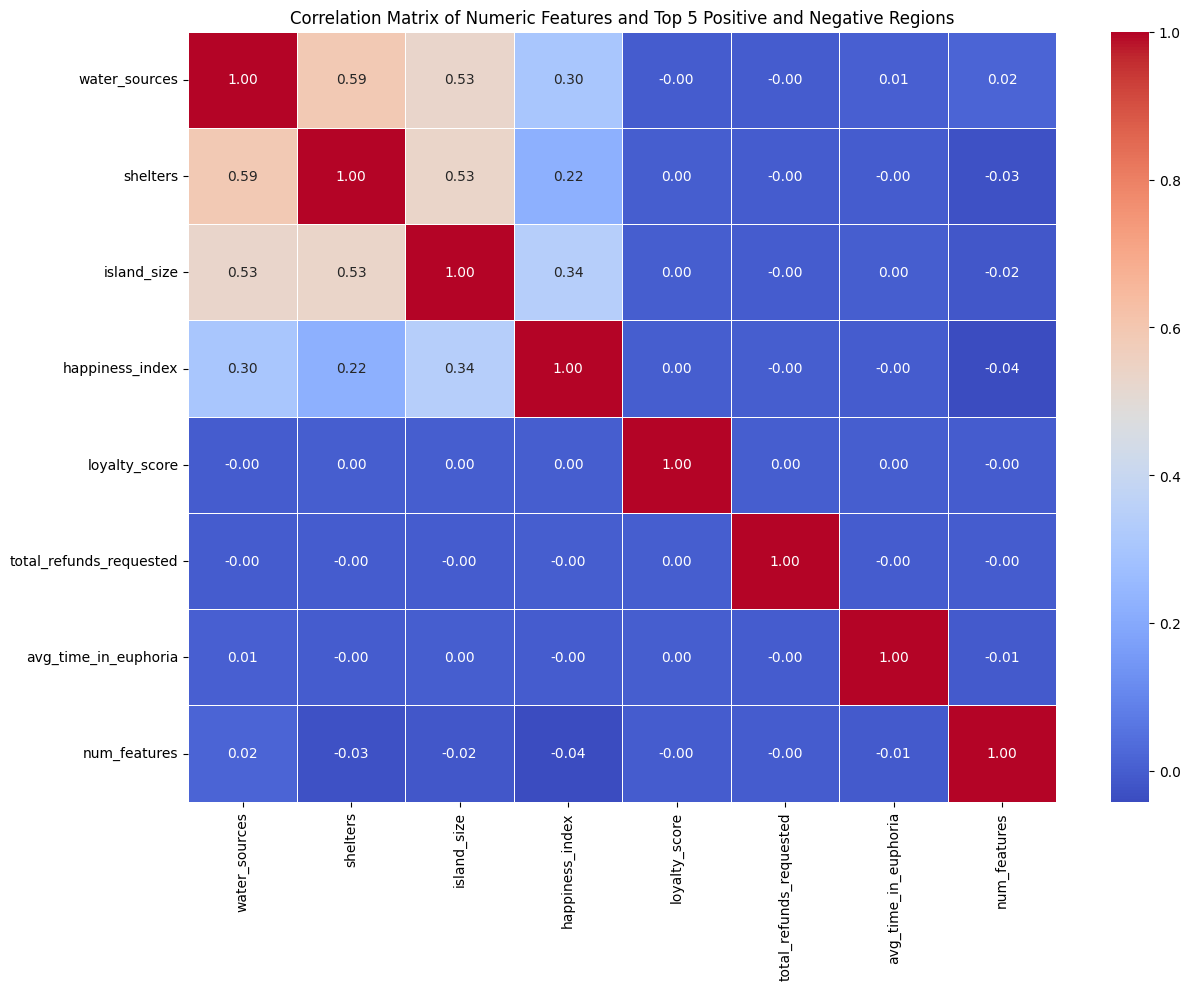

In [218]:
# Identify the numeric columns
columns_to_correlate = euphoria_data.select_dtypes(include=['number']).columns.tolist()
# Compute correlation matrix
extended_correlation_matrix = euphoria_data[columns_to_correlate].corr()

# Plot the extended correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(extended_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features and Top 5 Positive and Negative Regions')
plt.show()

##### **Reasons for Removing the `features` Column**
1. **No Meaningful Correlation**:
   - The highest correlation is only 0.09, which is negligible in terms of predictive power.
   - Most amenities have correlations close to zero or negative, indicating no useful relationship with `happiness_index`.

2. **Simplification of the Dataset**:
   - Retaining unnecessary columns adds computational overhead and may confuse models during training.

3. **Avoiding Noise**:
   - Columns with minimal relevance introduce noise, potentially reducing model accuracy.

4. **Resource Efficiency**:
   - With a large dataset (~90,000 rows), reducing columns helps streamline analysis and model building.


In [219]:
# Check and drop the 'features' and 'num_features' columns if they exist
columns_to_remove = ['features']

# Filter for columns that exist in the DataFrame
columns_to_drop = [col for col in columns_to_remove if col in euphoria_data.columns]

if columns_to_drop:
    euphoria_data.drop(columns=columns_to_drop, inplace=True)
    print(f"Removed columns: {columns_to_drop}")
    print(f"Updated dataset shape: {euphoria_data.shape}")
else:
    print("No specified columns found to remove.")


Removed columns: ['features']
Updated dataset shape: (89339, 13)


<Figure size 1200x600 with 0 Axes>

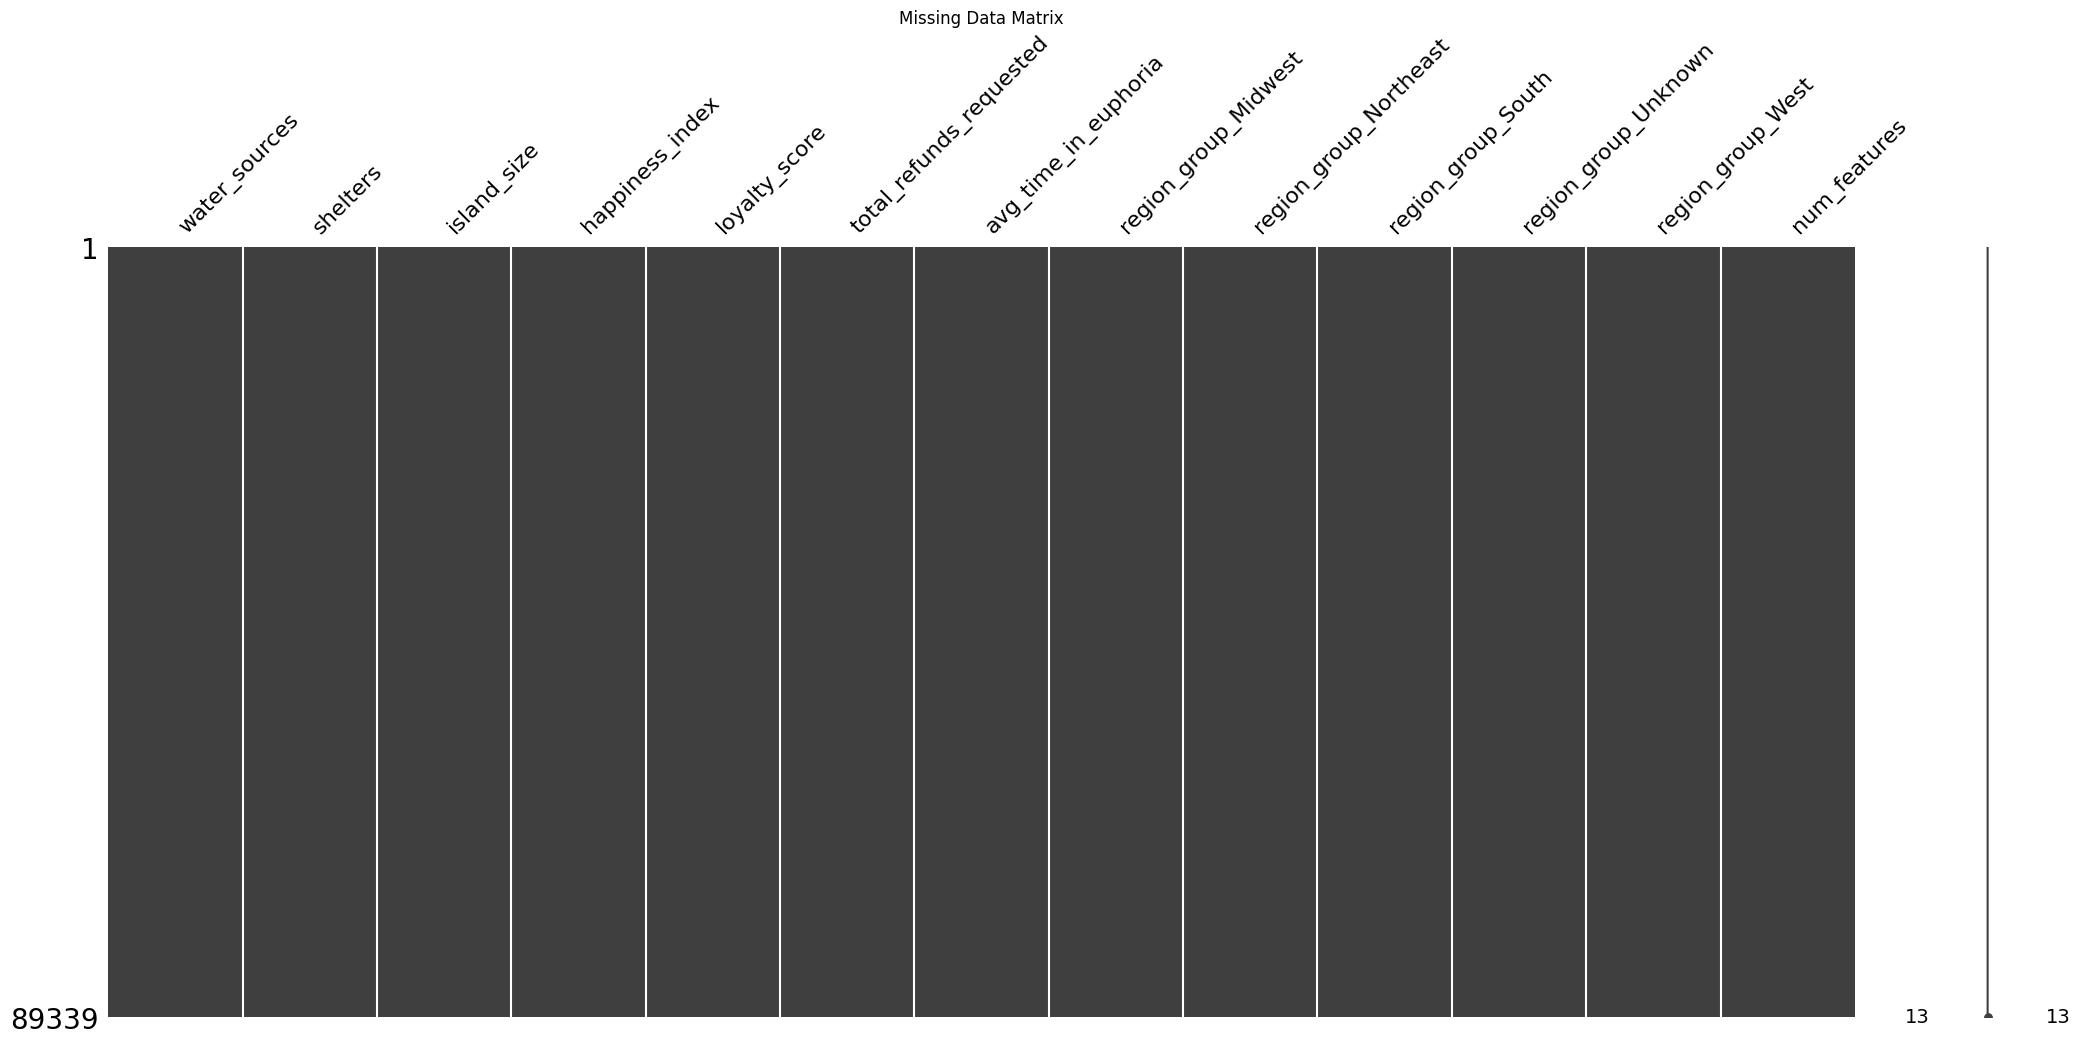

In [220]:
# Visualize missing data
import missingno as msno

# Missing data matrix
plt.figure(figsize=(12, 6))
msno.matrix(euphoria_data)
plt.title("Missing Data Matrix")
plt.show()

## Handling Outliers

### Finding Outliers

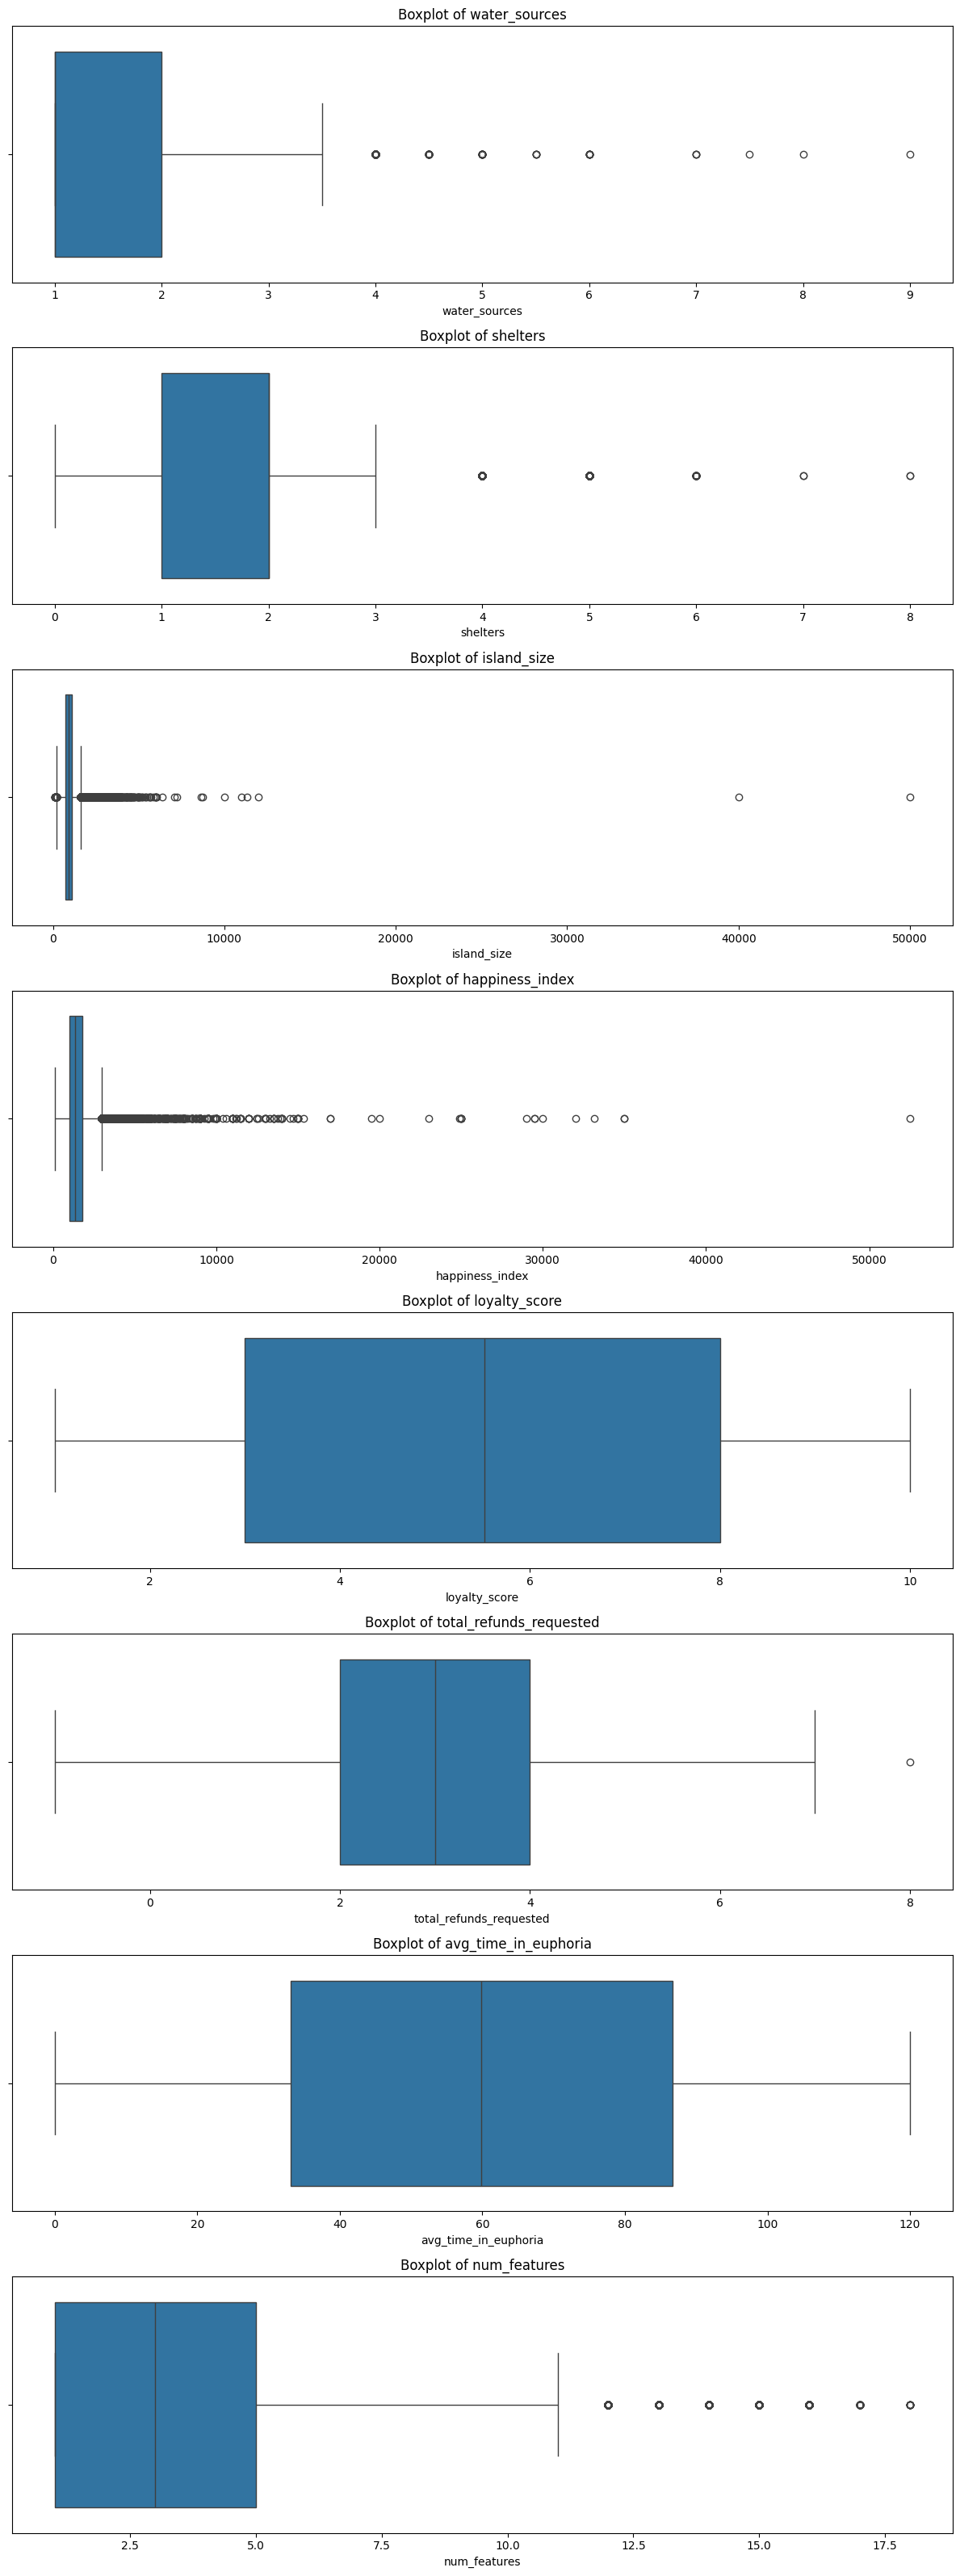

In [221]:
# List of numeric columns
numeric_columns = euphoria_data.select_dtypes(include=['number']).columns.tolist()

# Set the figure size
plt.figure(figsize=(12, len(numeric_columns) * 4))

# Create individual boxplots for each column
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 1, i)
    sns.boxplot(data=euphoria_data, x=col)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.tight_layout()  # Adjusts spacing between subplots

# Show the plots
plt.show()


#### Z-Score Detection

In [222]:
from scipy.stats import zscore

# Dictionary to store outliers for each column
outliers_zscore = {}

# Define the Z-score threshold for detecting outliers
z_threshold = 3

# Loop through numeric columns
for col in numeric_columns:
    # Compute Z-scores for the column (excluding NaN values)
    z_scores = zscore(euphoria_data[col].dropna())
    
    # Identify outliers using the Z-score threshold
    outliers_zscore[col] = euphoria_data.loc[(abs(z_scores) > z_threshold)].index

# Count outliers in each column
outlier_counts_zscore = {col: len(indices) for col, indices in outliers_zscore.items()}

# Display the results
print("Outlier counts using Z-score method:")
print(outlier_counts_zscore)


Outlier counts using Z-score method:
{'water_sources': 343, 'shelters': 1505, 'island_size': 931, 'happiness_index': 912, 'loyalty_score': 0, 'total_refunds_requested': 970, 'avg_time_in_euphoria': 0, 'num_features': 1805}


### Z-Score Capping

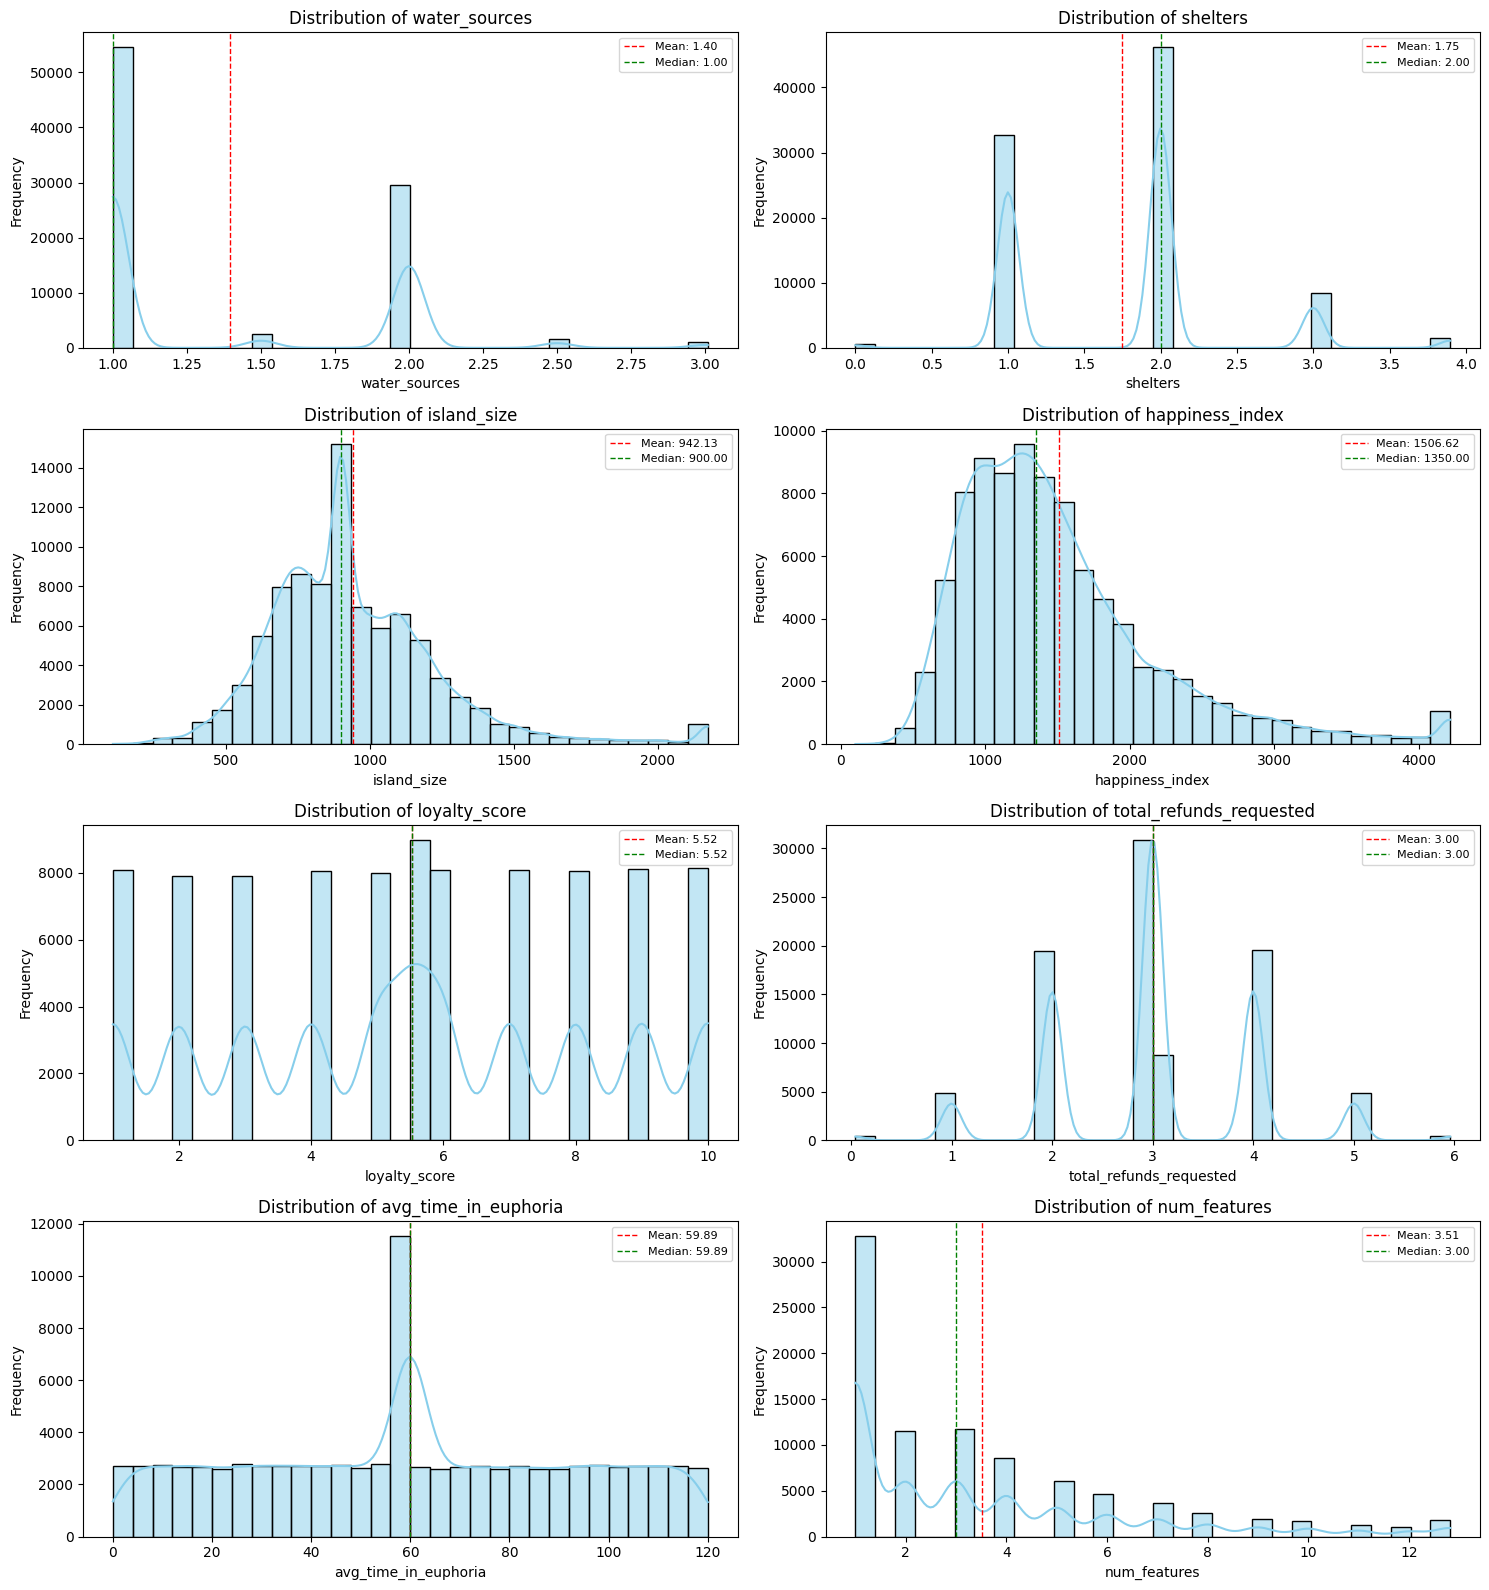

In [223]:
import numpy as np


# Function to cap outliers using Z-score
def cap_outliers_zscore(df, numeric_columns, threshold=3):
    """
    Cap outliers in each numeric column using the Z-score method.
    Outliers are capped at the threshold value.
    """
    for col in numeric_columns:
        z_scores = zscore(df[col])
        mean = df[col].mean()
        std_dev = df[col].std()

        upper_cap = mean + threshold * std_dev
        lower_cap = mean - threshold * std_dev

        df[col] = np.where(df[col] > upper_cap, upper_cap, df[col])
        df[col] = np.where(df[col] < lower_cap, lower_cap, df[col])
    
    return df

# Apply the capping function
euphoria_data = cap_outliers_zscore(euphoria_data.copy(), numeric_columns)

plot_numeric_distributions(euphoria_data, numeric_columns)

## Preparation for clustering

### Normalization

We use **MinMaxScaler** because:

1. **KMeans Requires Equal Feature Contribution**: MinMaxScaler ensures all features are on the same scale (e.g., `[0, 1]`), so no single feature (like `island_size`) dominates the distance calculations.

2. **Handles Different Feature Ranges**: It works well with features that have vastly different ranges, such as large numeric values (`island_size`) and binary values (one-hot encoded regions).

3. **No Assumption About Distribution**: MinMaxScaler is suitable for features with non-Gaussian distributions, such as uniform or binary data.

4. **Improves Interpretability**: Scaled data remains intuitive, with values between 0 (minimum) and 1 (maximum), making it easier to analyze.

5. **Better Fit for Distance-Based Algorithms**: It’s ideal for KMeans and similar clustering methods, which are sensitive to the scale of features.

In [224]:
from sklearn.preprocessing import MinMaxScaler

# Initialize Min-Max Scaler
scaler = MinMaxScaler()

# Apply Min-Max Scaling to numeric columns
euphoria_data[numeric_columns] = scaler.fit_transform(euphoria_data[numeric_columns])

# Check results
print(euphoria_data[numeric_columns].describe())


       water_sources      shelters   island_size  happiness_index  loyalty_score  total_refunds_requested  avg_time_in_euphoria  num_features
count   89339.000000  89339.000000  89339.000000     89339.000000   89339.000000             89339.000000          89339.000000  89339.000000
mean        0.197294      0.448516      0.404217         0.341506       0.502009                 0.500003              0.499084      0.212658
std         0.258592      0.178043      0.144395         0.169906       0.302953                 0.166130              0.274286      0.254682
min         0.000000      0.000000      0.000000         0.000000       0.000000                 0.000000              0.000000      0.000000
25%         0.000000      0.256571      0.310366         0.222148       0.222222                 0.330643              0.276292      0.000000
50%         0.000000      0.513142      0.383848         0.303481       0.502009                 0.499727              0.499084      0.169146
75%   

### Standard Scaler

In [225]:
# from sklearn.preprocessing import StandardScaler

# # Initialize Min-Max Scaler
# scaler = StandardScaler()

# # Apply Min-Max Scaling to numeric columns
# euphoria_data[numeric_columns] = scaler.fit_transform(euphoria_data[numeric_columns])

# # Check results
# print(euphoria_data[numeric_columns].describe())

### Correlation Matrix

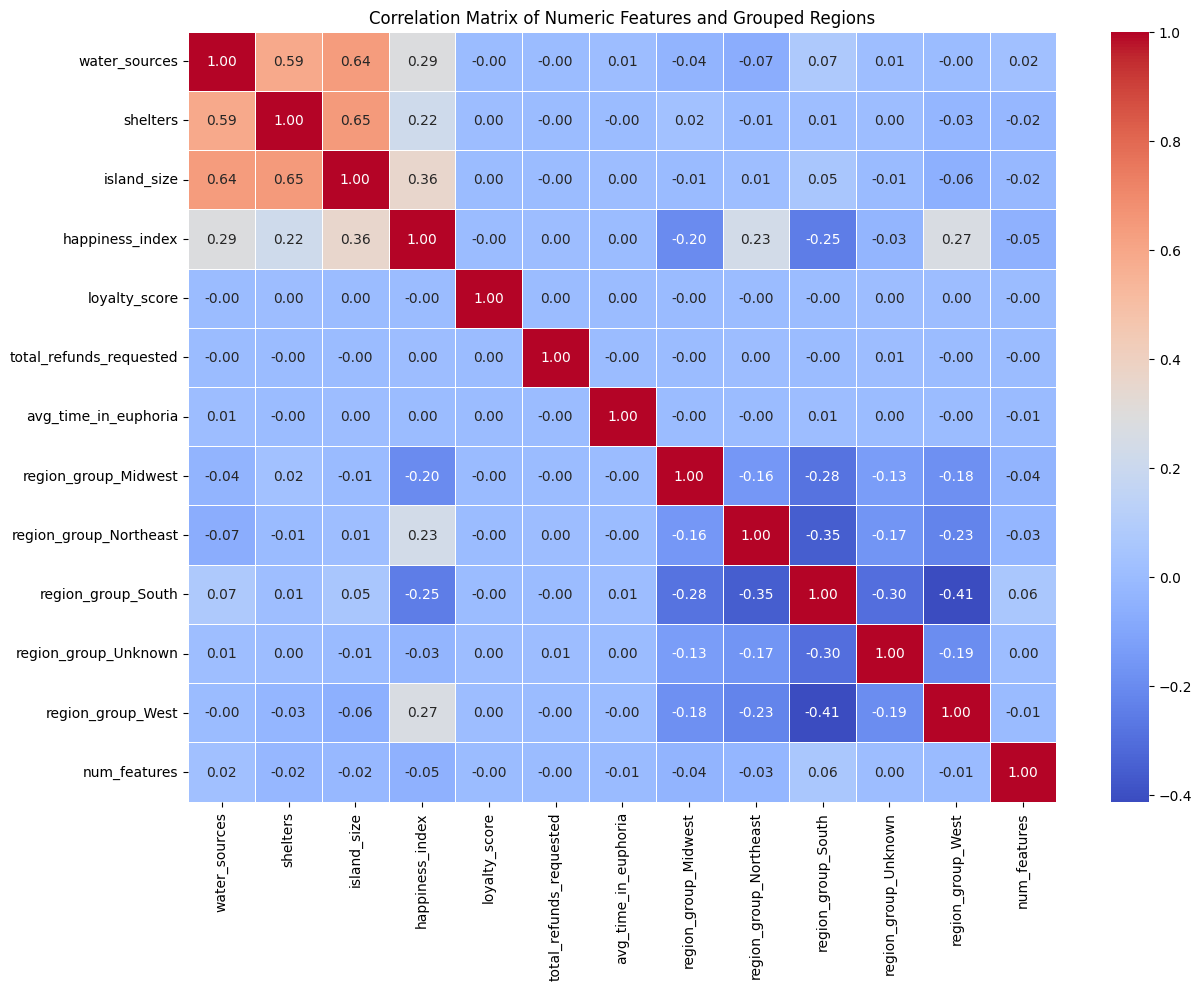

In [226]:
# Identify the numeric columns
columns_to_correlate = euphoria_data.columns.tolist()

# Compute correlation matrix
extended_correlation_matrix = euphoria_data[columns_to_correlate].corr()

# Plot the extended correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(extended_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features and Grouped Regions')
plt.show()

#### Dropping loyalty_score and total_refunds_requested

In [227]:
# euphoria_data = euphoria_data.drop(columns=['loyalty_score', 'total_refunds_requested'], errors='ignore')
# print(f"Updated dataset shape: {euphoria_data.shape}")

## K-Means Clustering

### Elbow Method

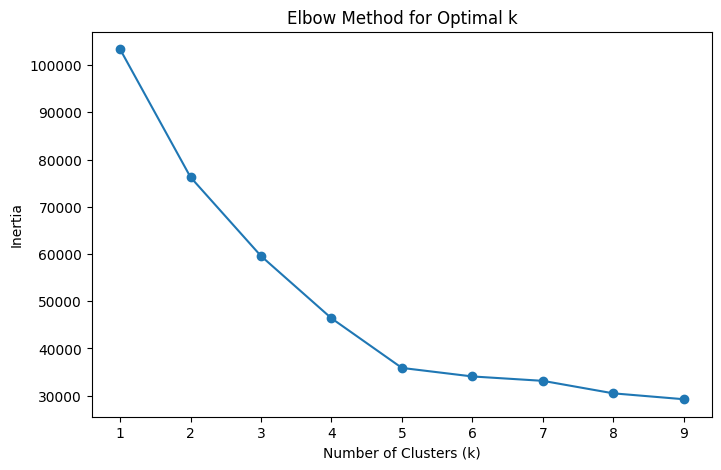

In [228]:
from sklearn.cluster import KMeans

# Select the numeric columns for clustering
clustering_data_k_means = euphoria_data.copy()

features = euphoria_data.columns.tolist()
#features = ['island_size', 'happiness_index', 'water_sources', 'region_CA', 'region_MA', 'region_Other']
X = clustering_data_k_means[features]

# Determine the optimal number of clusters using Elbow Method
inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

### Applying Clustering

kmeans_cluster
0    34729
2    18877
3    14755
4    10973
1    10005
Name: count, dtype: int64


c:\Users\matte\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


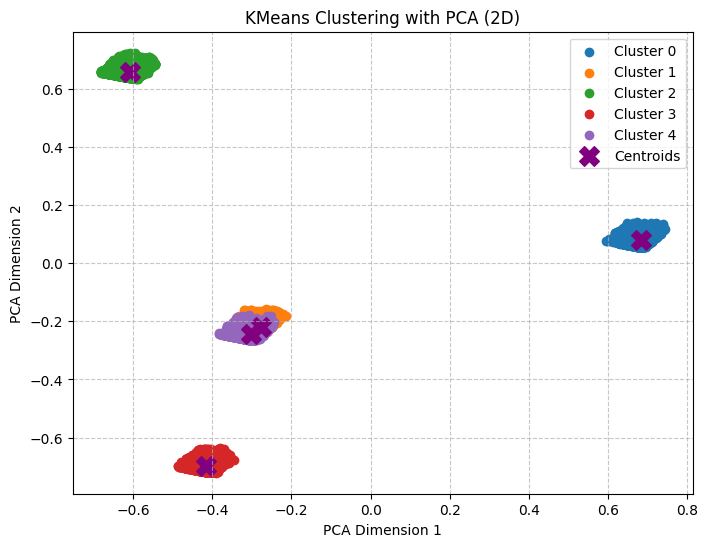

In [231]:
from sklearn.decomposition import PCA

# Apply K-Means with the chosen number of clusters
optimal_k = 5  # Chosen based on the Elbow Method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit(X)

# Add cluster labels to the dataset
clustering_data_k_means['kmeans_cluster'] = clusters.labels_

# Print cluster counts
print(clustering_data_k_means['kmeans_cluster'].value_counts())

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the clusters in 2D
plt.figure(figsize=(8, 6))
for cluster in range(kmeans.n_clusters):
    cluster_data = X_pca[clustering_data_k_means['kmeans_cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')

# Plot cluster centers in PCA-reduced space
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=200, c='purple', marker='X', label='Centroids')
plt.title('KMeans Clustering with PCA (2D)')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


### Silhouette Score

In [232]:
from sklearn.metrics import silhouette_score

# Pass the actual feature data (X) to silhouette_score
silhouette_kmeans = silhouette_score(X, clustering_data_k_means['kmeans_cluster'])
print(f'Silhouette Score: {silhouette_kmeans}')

Silhouette Score: 0.4858664314996169


In [195]:
# from sklearn.metrics import silhouette_score

# silhouette_scores = []
# k_range = range(2, 7)
# for k in k_range:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(X)
#     silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# # Plot Silhouette Score
# plt.figure(figsize=(8, 5))
# plt.plot(k_range, silhouette_scores, marker='o', color='green', label='Silhouette Score')
# plt.title('Silhouette Score for Optimal k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.legend()
# plt.show()

### Cluster Summary

In [233]:
cluster_summary = clustering_data_k_means.groupby('kmeans_cluster')[features].mean()
print("Cluster Summary:")
print(cluster_summary.T)

Cluster Summary:
kmeans_cluster                  0         1         2         3         4
water_sources            0.221493  0.169155  0.196962  0.156308  0.202040
shelters                 0.451075  0.460344  0.438989  0.446058  0.449328
island_size              0.414148  0.400456  0.387629  0.407148  0.400811
happiness_index          0.288588  0.244553  0.429006  0.430853  0.326721
loyalty_score            0.500921  0.498043  0.504306  0.501429  0.505898
total_refunds_requested  0.499449  0.499933  0.498621  0.501254  0.502521
avg_time_in_euphoria     0.500885  0.498068  0.497375  0.497456  0.499442
region_group_Midwest     0.000000  1.000000  0.000000  0.000000  0.000000
region_group_Northeast   0.000000  0.000000  0.000000  1.000000  0.000000
region_group_South       1.000000  0.000000  0.000000  0.000000  0.000000
region_group_Unknown     0.000000  0.000000  0.000000  0.000000  1.000000
region_group_West        0.000000  0.000000  1.000000  0.000000  0.000000
num_features         

## DBSCAN

### Finding Best Hyperparamenter

In [41]:
from sklearn.cluster import DBSCAN

# Downsample the dataset
downsample_frac = 0.2  # Use 20% of the data for tuning
X_sample = X.sample(frac=downsample_frac, random_state=42)
clustering_data_dbscan = X_sample.copy()

# Hyperparameter tuning on the downsampled dataset
best_score = -1
best_params = None
results = []

eps_range = np.arange(0.05, 0.3, 0.05)  # Range of eps values
min_samples_range = range(3, 10)  # Range of min_samples values

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_sample)
        
        # Exclude noise points (-1) for Silhouette Score calculation
        if len(set(labels)) > 1 and -1 in labels:
            score = silhouette_score(X_sample[labels != -1], labels[labels != -1])
            results.append({'eps': eps, 'min_samples': min_samples, 'silhouette_score': score})
            
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

# Display the best parameters
print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {best_score}")

Best Parameters: {'eps': 0.25, 'min_samples': 3}
Best Silhouette Score: 0.6462625882440203


### Applying DBSCAN

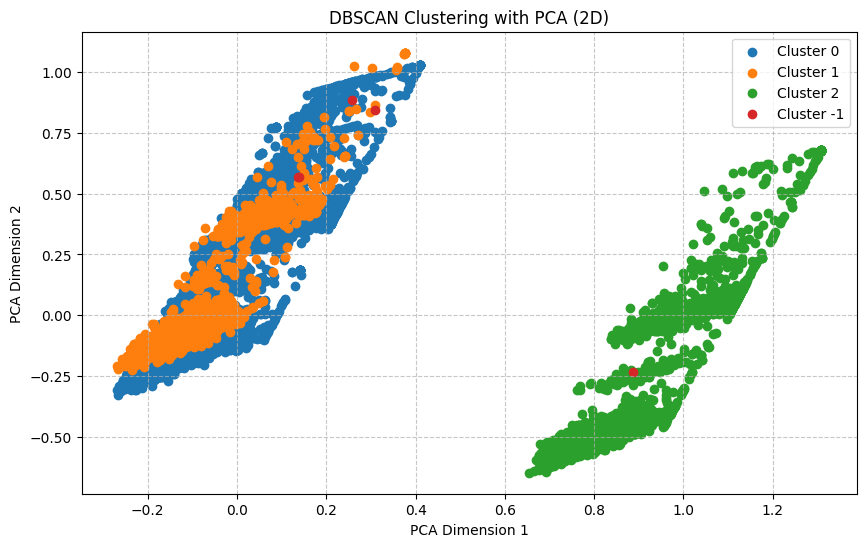

In [42]:
# Apply the best parameters to the full dataset
clustering_data_dbscan = X_sample.copy()
X_full = X_sample.copy()
dbscan_full = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
full_labels = dbscan_full.fit_predict(X_full)

# Add cluster labels to the full dataset
clustering_data_dbscan['dbscan_cluster'] = full_labels

# Visualize the results using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_full)

plt.figure(figsize=(10, 6))
for cluster_label in set(full_labels):
    cluster_data = X_pca[full_labels == cluster_label]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster_label}')
plt.title('DBSCAN Clustering with PCA (2D)')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Cluster Summary

In [37]:
cluster_summary = clustering_data_dbscan.groupby('dbscan_cluster')[features].mean()
print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
                island_size  happiness_index  water_sources  region_CA  region_MA
dbscan_cluster                                                                   
-1                 0.840111         0.758826       0.856299      0.375     0.5625
 0                 0.404006         0.309576       0.199929      0.000     0.0000
 1                 0.427692         0.511426       0.168679      0.000     1.0000
 2                 0.385795         0.541554       0.198943      1.000     0.0000


## Hierarchical Clustering

### Hyperparameter Tuning

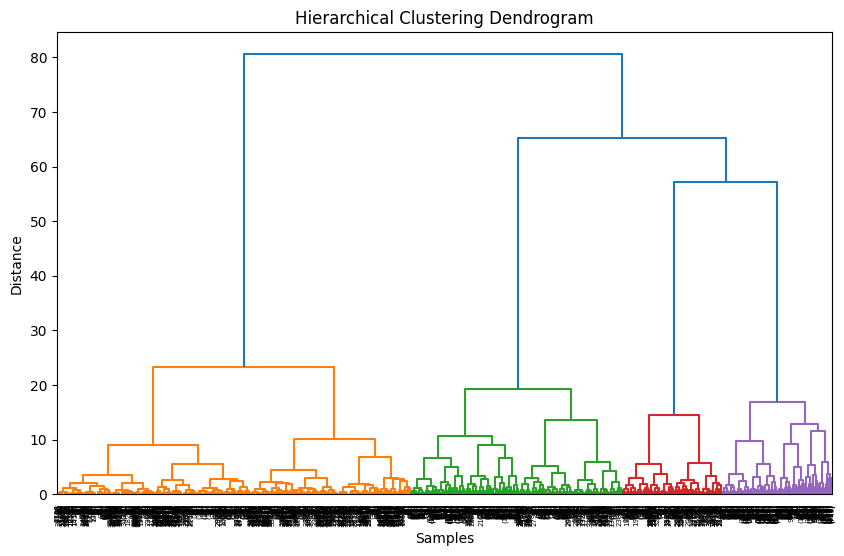

Best Number of Clusters: 4
Best Silhouette Score: 0.6245241653870713


In [45]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Downsample the dataset
downsample_frac = 0.4  # Use 20% of the data for clustering
X_sample = X.sample(frac=downsample_frac, random_state=42)

# Generate Dendrogram
plt.figure(figsize=(10, 6))
linked = linkage(X_sample, method='ward')  # 'ward' minimizes variance in clusters
dendrogram(linked, truncate_mode='level', p=10)  # Adjust `p` to show fewer cluster levels
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

# Evaluate with Silhouette Score and choose the number of clusters
best_score = -1
best_n_clusters = None
results = []

for n_clusters in range(2, 7):  # Try different numbers of clusters
    hc = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    labels = hc.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    results.append({'n_clusters': n_clusters, 'silhouette_score': score})
    
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

print(f"Best Number of Clusters: {best_n_clusters}")
print(f"Best Silhouette Score: {best_score}")

### Applying Hierarchical Clustering

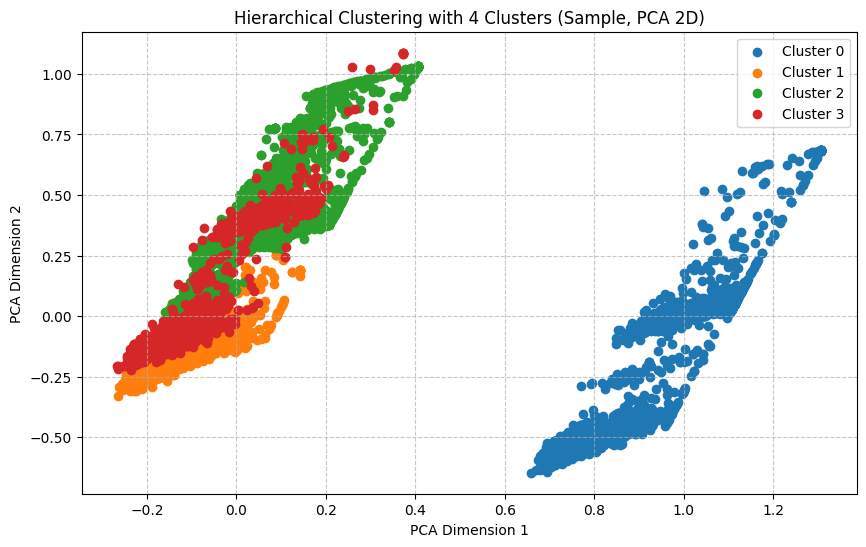

In [39]:
# Apply clustering to the sampled dataset
hc_sample = AgglomerativeClustering(n_clusters=best_n_clusters, metric='euclidean', linkage='ward')
sample_labels = hc_sample.fit_predict(X_sample)

# Add cluster labels to the sampled dataset
clustering_data_hc = X_sample.copy()
clustering_data_hc['hc_cluster'] = sample_labels

# Visualize Clustering with PCA
pca = PCA(n_components=2)
X_pca_sample = pca.fit_transform(X_sample)

plt.figure(figsize=(10, 6))
for cluster_label in set(sample_labels):
    cluster_data = X_pca_sample[sample_labels == cluster_label]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster_label}')
plt.title(f'Hierarchical Clustering with {best_n_clusters} Clusters (Sample, PCA 2D)')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Cluster Summary

In [40]:
cluster_summary = clustering_data_hc.groupby('hc_cluster')[features].mean()
print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
            island_size  happiness_index  water_sources  region_CA  region_MA
hc_cluster                                                                   
0              0.386998         0.538614       0.200991        1.0        0.0
1              0.336293         0.278721       0.000375        0.0        0.0
2              0.507806         0.358308       0.504377        0.0        0.0
3              0.428942         0.509720       0.166728        0.0        1.0
